# CorrSeg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

# sklearn
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, cross_val_score, TimeSeriesSplit, train_test_split

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchsummary import summary
from torchvision import models, datasets
from torchvision.transforms import v2

/Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <B2020C3B-209A-3D8E-86A7-CC634C84A0EF> /Users/Andrej/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. Whil

### Loading data

                  0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_10_patch_0   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_1   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_10  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_11  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_12  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...              .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_15_patch_95  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_96  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_97  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_98  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_99  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                  1290  1291  1292  1293  1294  129

<Axes: >

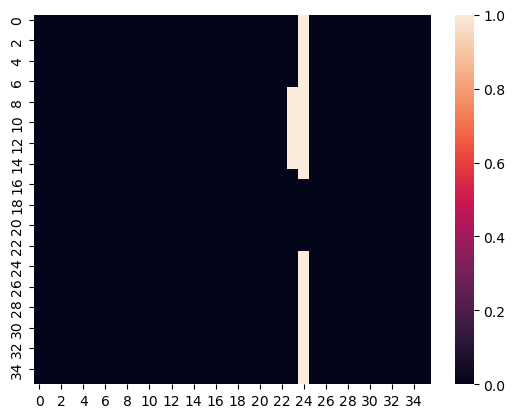

In [2]:
# Read file
y_train = pd.read_csv('./y_train_PlZf4rH.csv', index_col=0) #Table with index being the name of the patch
print(y_train)
y_1_130 = np.array(y_train.loc['well_1_patch_130'])

# Access to one patch label
sns.heatmap(np.array(y_train.loc['well_1_patch_40']).reshape(36, 36))

In [3]:
path = Path('./images')
image_paths = np.array([x for x in path.iterdir()])
image_names = np.array([str(x).split('/')[1].split('.')[0] for x in image_paths]) # extracting image path names into a list in order to reindex labels
n = len(image_paths)
images_array = np.empty((n, 36, 36), dtype=np.float32)

for i, path in enumerate(image_paths):
    if path != image_paths[i]: 
        print('chaos')
    # print("at ", i, "of", n)
    images_array[i] = np.load(path)


In [4]:
labels = y_train.reindex(image_names)
print(labels.shape)

(9674, 1296)


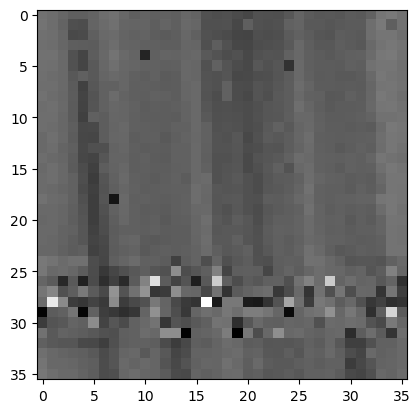

In [5]:
plt.imshow(images_array[9] * 255, cmap='gray')

In [6]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## EDA

In [7]:
def plot_mask_and_image(img, label):    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    print(type(x))
    print(x.shape)

    sns.heatmap(label, ax=axes[0])
    axes[0].set_title('Heatmap')
    axes[0].set_aspect('equal')

    axes[1].imshow(img, cmap='gray')
    axes[1].set_title('Image')

    plt.tight_layout()

In [8]:
def plot_two_images(x1, x2):

    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    print(np.unique(x1))

    axes[0].imshow(x1, cmap='gray')
    axes[0].set_title('Image OG')
    axes[0].set_aspect('equal')

    axes[1].imshow(x2, cmap='gray')
    axes[1].set_title('Image Flip')
    axes[0].set_aspect('equal')

    plt.tight_layout()

In [9]:
print(np.unique(images_array))
# np.equal(images, nan)
np.argwhere(images_array == np.nan)

[-9.9925000e+02 -9.9900000e+02 -9.3992406e-01 ...  4.2167890e-01
  4.7034341e-01            nan]


array([], shape=(0, 3), dtype=int64)

In [10]:
np.min(images_array)

nan

## Preprocessing

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
images_array_imp = imputer.fit_transform(images_array.reshape(n, 36*36)).reshape(n, 36, 36)

In [12]:
# leaving outliers for now, using robust scaler
scaler = RobustScaler()
for i, image in enumerate(images_array_imp):
    scaler.fit_transform(image)

In [13]:
labels = y_train.reindex(image_names)
flip_amount = len(labels) # 4000

In [14]:
in_img = torch.tensor(images_array_imp[:flip_amount], dtype=torch.float32, device=mps_device)
in_labels = torch.tensor(labels[:flip_amount].values.reshape(-1, 36, 36), dtype=torch.float32, device=mps_device)

#### Horizontal Flip

In [15]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=1),
])

out_img = transform(in_img)
out_labels = transform(in_labels)

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([in_img, out_img], 0)
labels_aug = torch.concat([in_labels, out_labels], 0)
img_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([19348, 36, 36])

#### Vertical Flip

In [16]:
transform = v2.Compose([
    v2.RandomVerticalFlip(p=1),
])
flip_amount = len(labels) # 4000
out_img = transform(in_img).to(mps_device)
out_labels = transform(in_labels).to(mps_device)

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([img_aug, out_img], 0)
labels_aug = torch.concat([labels_aug, out_labels], 0)

img_aug.shape
labels_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([29022, 36, 36])

[-0.04917306 -0.047216   -0.04526222 ...  0.02709413  0.02773702
  0.03081495]


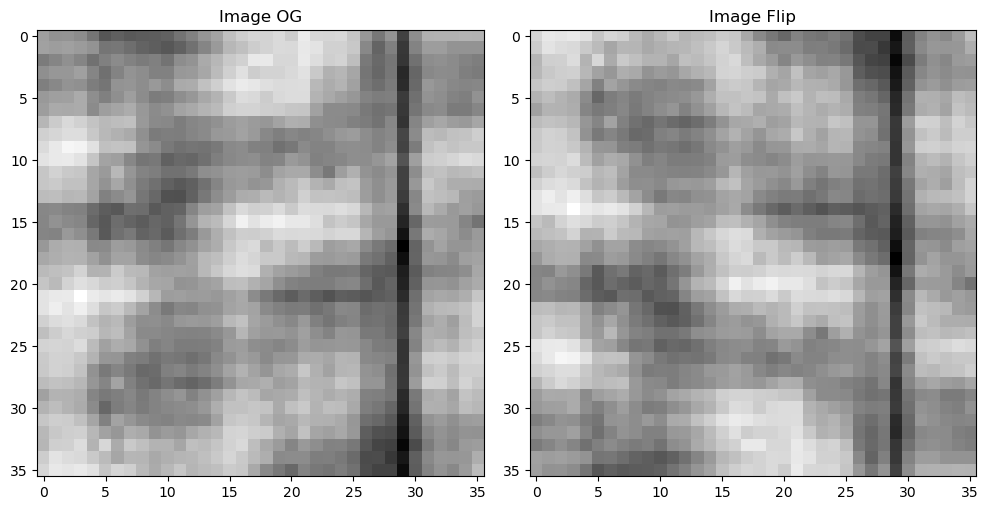

In [17]:
in_img[0]
id = 486

plot_two_images(in_img[id].cpu(), out_img[id].cpu())

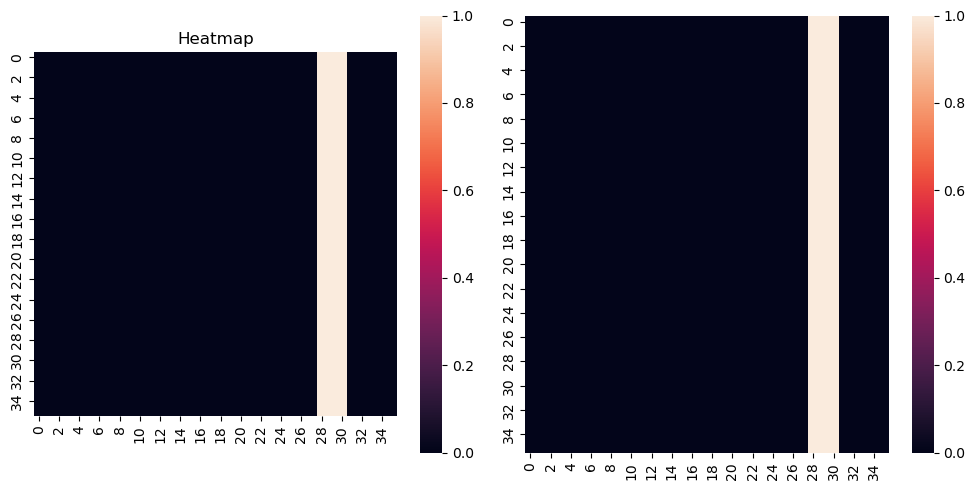

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(np.array(in_labels[id].cpu()).reshape(36, 36), ax=axes[0])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

sns.heatmap(np.array(out_labels[id].cpu()).reshape(36, 36), ax=axes[1])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

plt.tight_layout()

### Data augmentation

## Pipeline

In [19]:
torch.manual_seed(12)  # For reproducibility
indices = torch.randperm(len(labels))
print(indices[:10])

tensor([6781, 5987, 8880, 1142, 3557,  805, 4077, 2260, 1980, 7639])


In [20]:
torch.manual_seed(12)
print(np.unique(indices).shape)

(9674,)


In [21]:
indices = torch.randperm(len(img_aug))

img_shuffle = img_aug[indices]
print(indices[:10])
# labels_aug = labels_aug[indices]
labels_shuffle = labels_aug[indices]
id
print(img_aug[indices[485]])
print(img_shuffle[485])

for tens in out_img:
    if tens.max() == 1:
        print(tens)

for tens in img_shuffle:
    if tens.max() == 1:
        print(tens)


tensor([16455, 19006, 15684, 28245, 10883, 17910, 13161, 20425, 15798, 11250])
tensor([[-0.0678, -0.0149, -0.0057,  ..., -0.0021, -0.0031, -0.0082],
        [-0.0481, -0.0116,  0.0010,  ..., -0.0012, -0.0030, -0.0048],
        [-0.0419, -0.0158,  0.0013,  ...,  0.0049,  0.0031, -0.0015],
        ...,
        [ 0.0145,  0.0216,  0.0105,  ...,  0.0076, -0.0532,  0.0013],
        [ 0.0107,  0.0211,  0.0152,  ...,  0.0035, -0.0608, -0.0013],
        [ 0.0129,  0.0205,  0.0142,  ...,  0.0029, -0.0688, -0.0274]],
       device='mps:0')
tensor([[-0.0678, -0.0149, -0.0057,  ..., -0.0021, -0.0031, -0.0082],
        [-0.0481, -0.0116,  0.0010,  ..., -0.0012, -0.0030, -0.0048],
        [-0.0419, -0.0158,  0.0013,  ...,  0.0049,  0.0031, -0.0015],
        ...,
        [ 0.0145,  0.0216,  0.0105,  ...,  0.0076, -0.0532,  0.0013],
        [ 0.0107,  0.0211,  0.0152,  ...,  0.0035, -0.0608, -0.0013],
        [ 0.0129,  0.0205,  0.0142,  ...,  0.0029, -0.0688, -0.0274]],
       device='mps:0')


tensor([-0.0360, -0.0358, -0.0349,  ...,  0.0440,  0.0509,  0.0572],
       device='mps:0')
[-0.03600788 -0.03581595 -0.0349457  ...  0.04396585  0.05088395
  0.05720514]


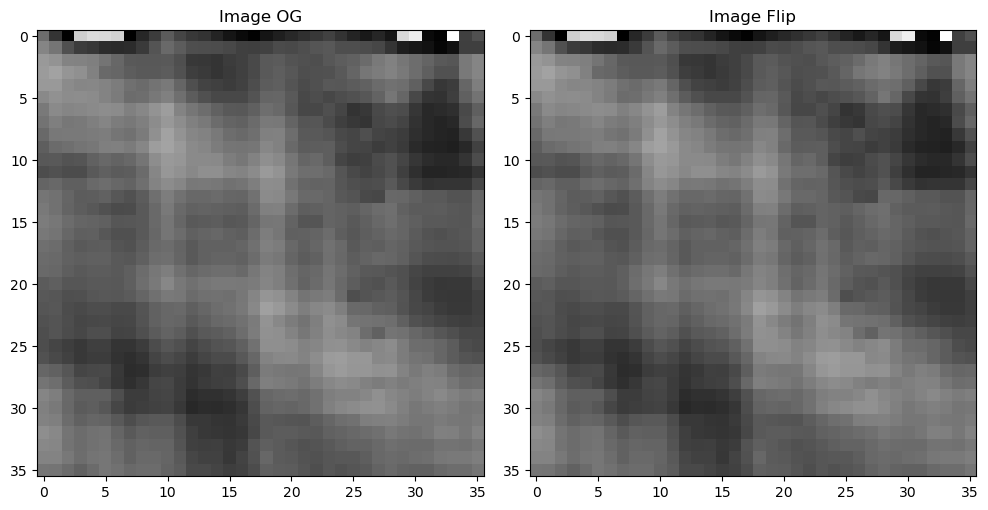

In [22]:
id = 1965
print(img_aug[indices[id]].unique())
plot_two_images(img_aug[indices[id]].cpu(), img_shuffle[id].cpu())

<class 'torch.Tensor'>
torch.Size([1])


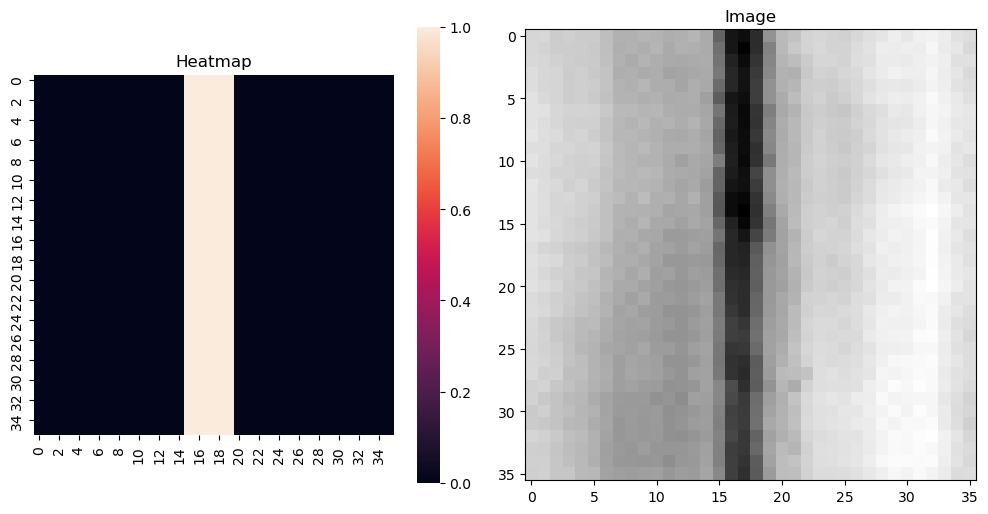

In [23]:
id = 1951
plot_mask_and_image(img_shuffle[id].cpu(), labels_shuffle[id].cpu())

In [24]:
cutoff = int(len(img_shuffle) * 0.8)
train_set = torch.utils.data.TensorDataset(
    img_shuffle[:cutoff], 
    labels_shuffle[:cutoff])
val_set = torch.utils.data.TensorDataset(
    img_shuffle[cutoff:], 
    labels_shuffle[cutoff:])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

## CNN

In [25]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            # nn.Dropout(p=0.5),
            # nn.BatchNorm2d(out_ch, device=mps_device),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, X):
        return self.conv(X)

In [26]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1) -> None:
        super().__init__()

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2, bias=False),
            # nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
    def forward(self, X):
        return self.deconv(X)

In [27]:
class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
                

    def forward(self, X):
        return self.conv(X)


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Encoding
        self.conv0 = (Down(1, 32))
        self.conv1 = (Down(32, 32, stride=2))
        self.conv2 = (Down(32, 64, stride=2))

        # Decoding
        self.deconv1 = (Up(64, 32))
        self.deconv2 = (Up(64, 32))
        self.conv3 = (OutConv(32, 1))



    def forward(self, x):
        # print("x", x.shape)
        # Encoder
        x0 = self.conv0(x)
        x1 = self.conv1(x0)
        # print("x1", x1.shape)
        x2 = self.conv2(x1)
        # print("x2", x2.shape)

 
        # Decoder
        x = self.deconv1(x2) # TODO remove relu
        # print("x3", x.shape)
        x = self.deconv2(torch.cat([x1, x], 1))
        # print("new ", x.shape)


        # print("sending", type(self.conv3(x)))
        #output
        # print(self.conv3(x))
        x = torch.sigmoid(self.conv3(x))
        
        return x

In [29]:
model = CNN()

In [30]:
from torchsummary import summary

summary(model, input_size=(1, 36, 36))

Layer (type:depth-idx)                   Param #
├─Down: 1-1                              --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  288
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  9,216
|    |    └─ReLU: 3-4                    --
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-5                  9,216
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-7                  9,216
|    |    └─ReLU: 3-8                    --
├─Down: 1-3                              --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-9                  18,432
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─ReLU: 3-12                   --
├─Up: 1-4                                --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-13        8,192
|    |

Layer (type:depth-idx)                   Param #
├─Down: 1-1                              --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  288
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  9,216
|    |    └─ReLU: 3-4                    --
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-5                  9,216
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-7                  9,216
|    |    └─ReLU: 3-8                    --
├─Down: 1-3                              --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-9                  18,432
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─ReLU: 3-12                   --
├─Up: 1-4                                --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-13        8,192
|    |

In [31]:
from torchmetrics import JaccardIndex

def jaccard_loss(y_true, y_pred, smooth=100.0):
    intersection = torch.sum( y_true * y_pred, axis=-1)
    union = torch.sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return (1 - jac) * smooth


Epoch [1/1000], Loss: 0.3284, Val Loss: 0.3896


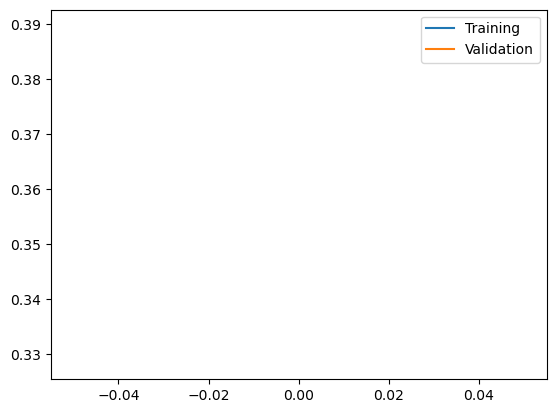

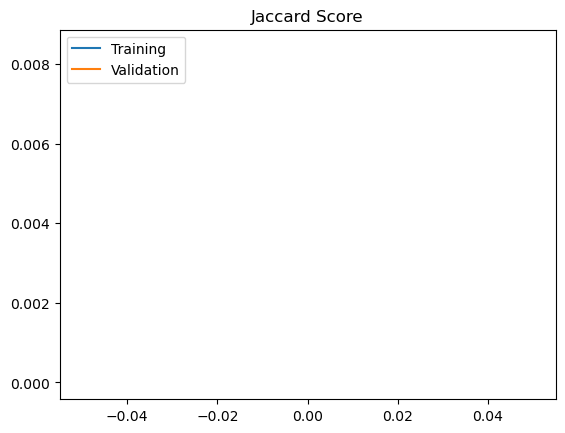

Epoch [2/1000], Loss: 0.2287, Val Loss: 0.3135


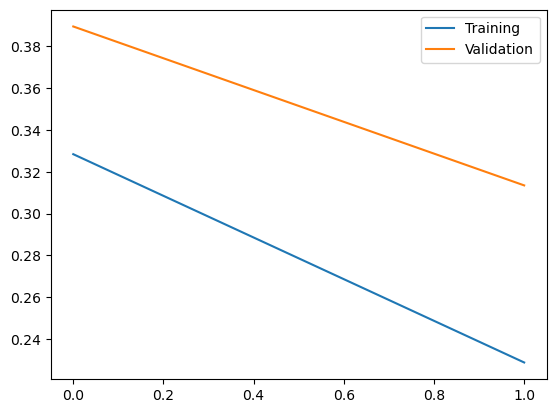

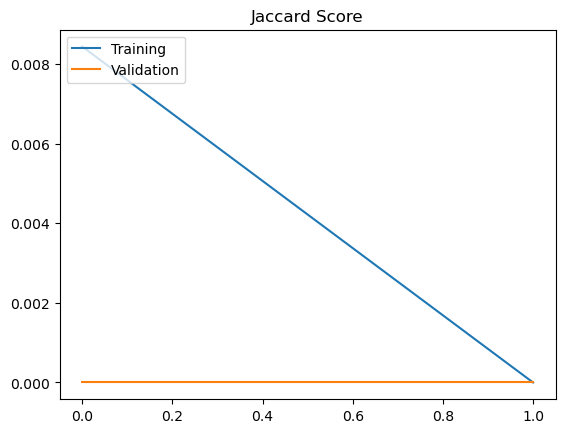

Epoch [3/1000], Loss: 0.2130, Val Loss: 0.2463


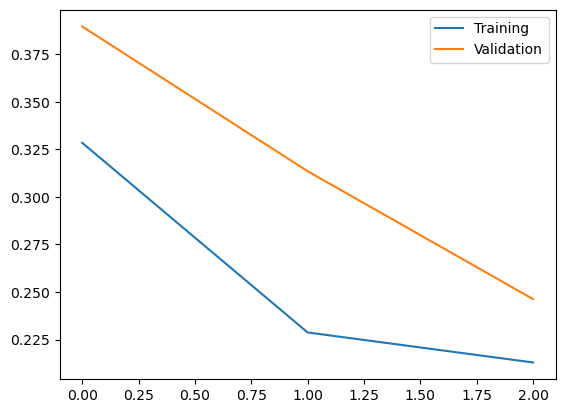

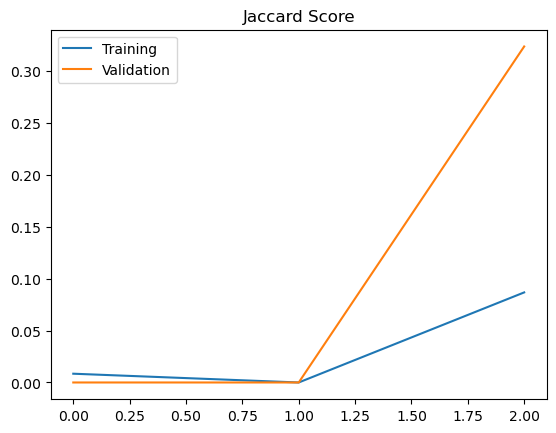

Epoch [4/1000], Loss: 0.1687, Val Loss: 0.2250


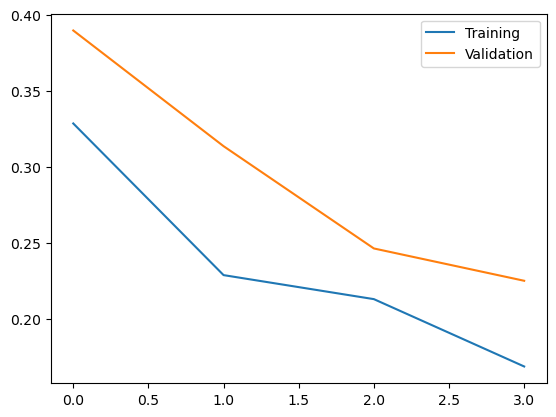

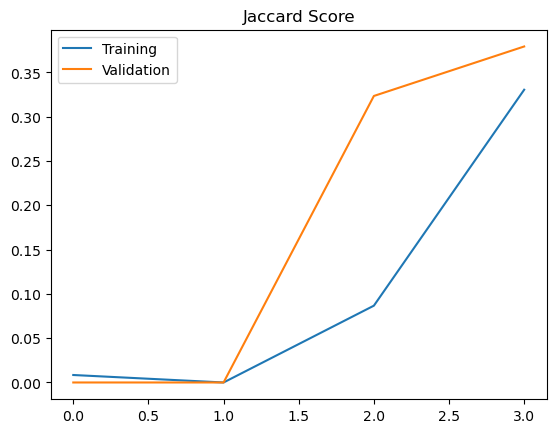

Epoch [5/1000], Loss: 0.4776, Val Loss: 0.2162


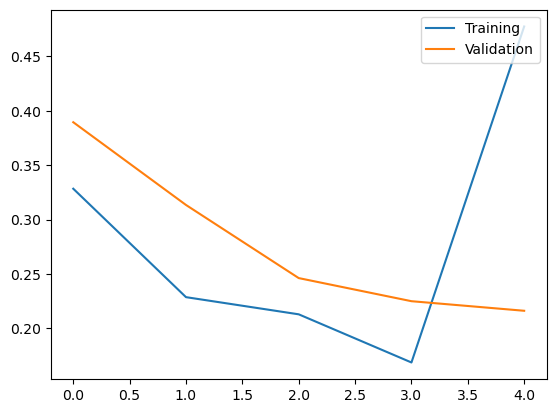

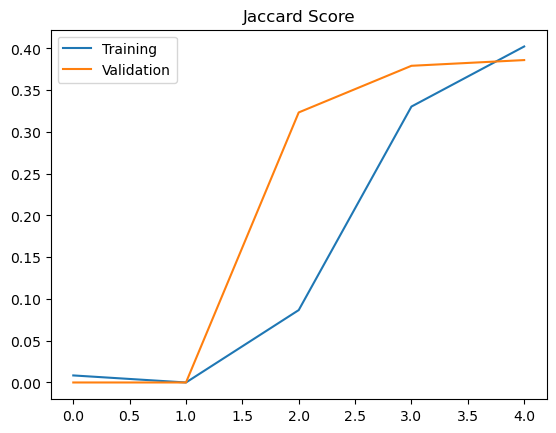

Epoch [6/1000], Loss: 0.1592, Val Loss: 0.2099


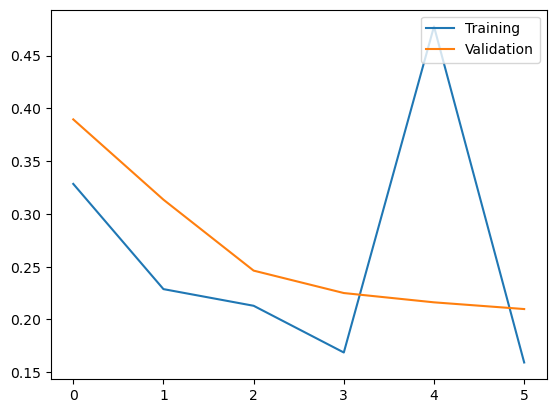

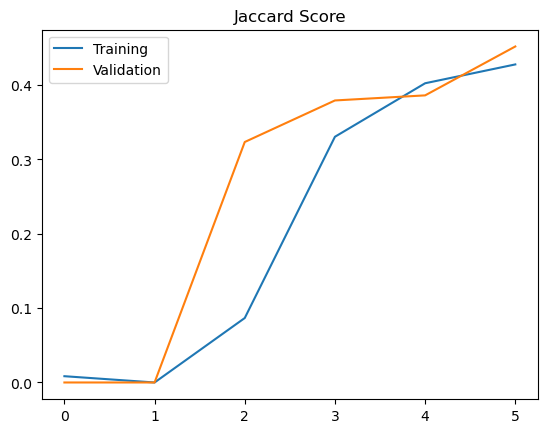

Epoch [7/1000], Loss: 0.1492, Val Loss: 0.2043


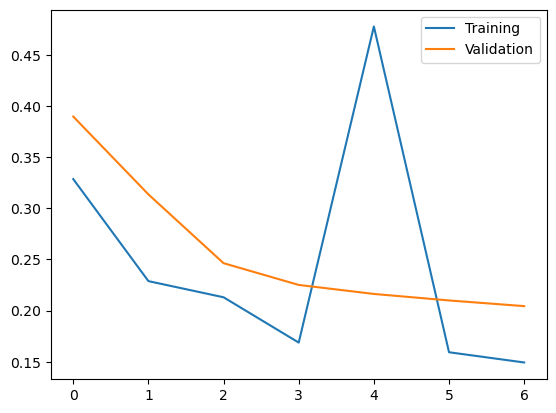

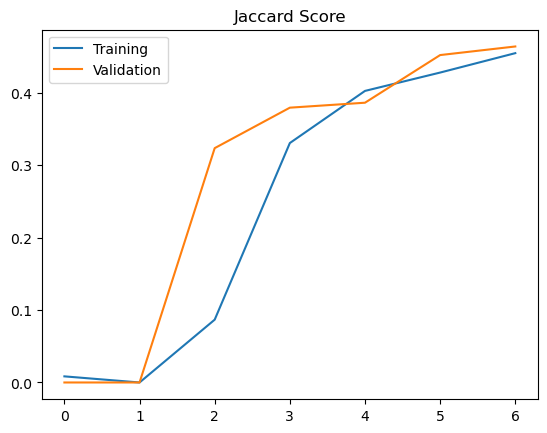

Epoch [8/1000], Loss: 0.1874, Val Loss: 0.2022


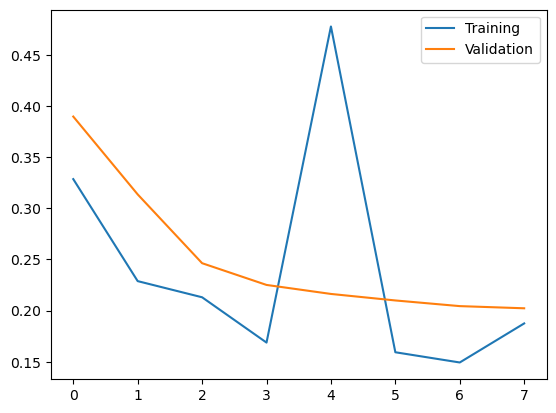

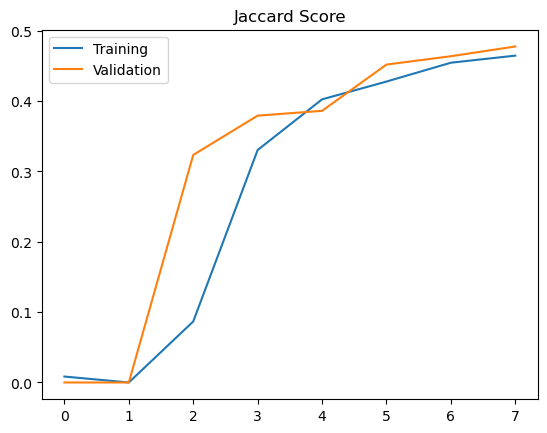

Epoch [9/1000], Loss: 0.1372, Val Loss: 0.1998


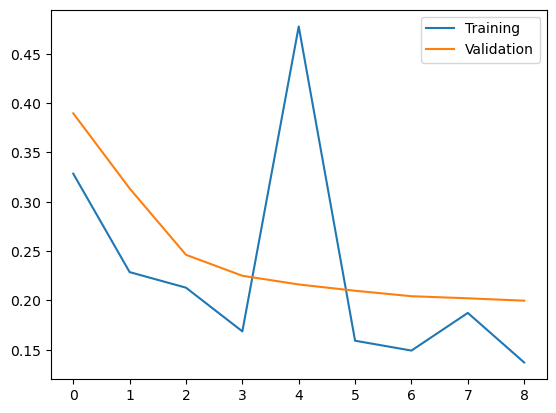

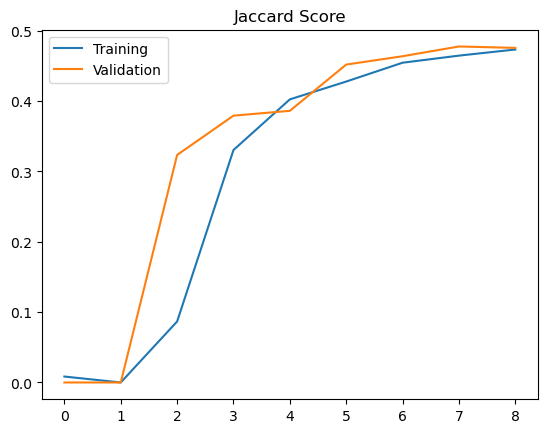

Epoch [10/1000], Loss: 0.1401, Val Loss: 0.1972


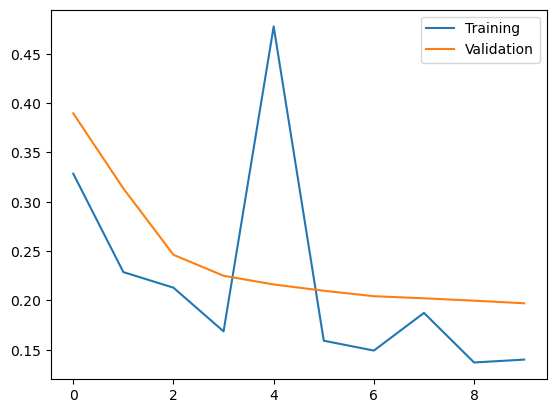

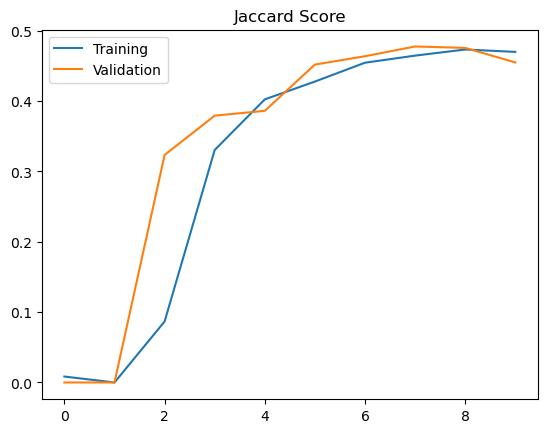

Epoch [11/1000], Loss: 0.2072, Val Loss: 0.1942


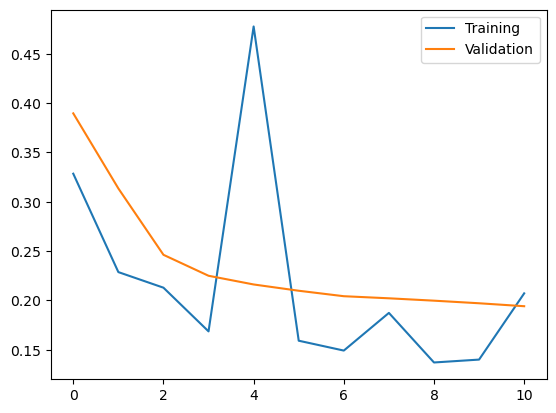

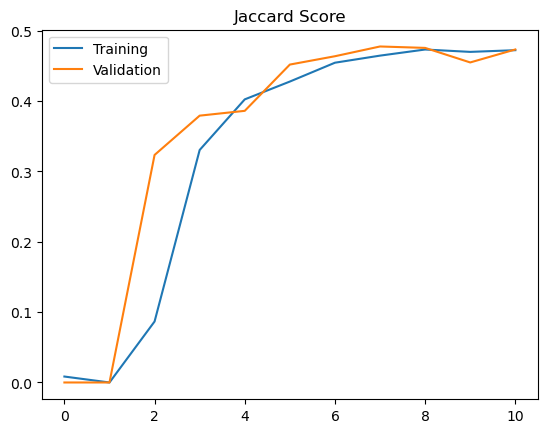

Epoch [12/1000], Loss: 0.3280, Val Loss: 0.1981


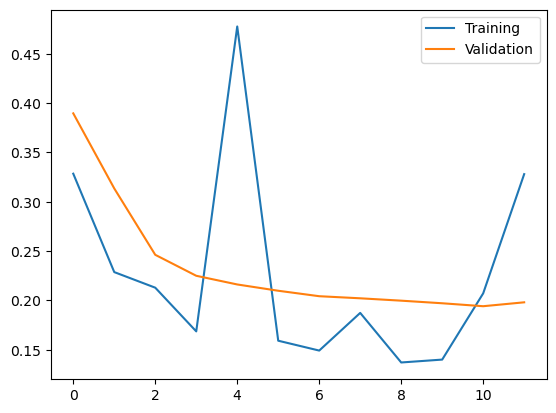

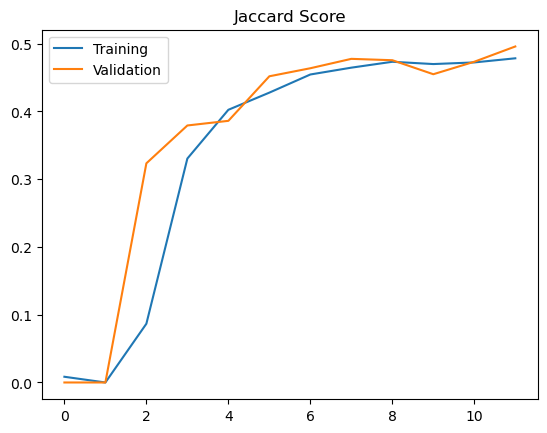

Epoch [13/1000], Loss: 0.1446, Val Loss: 0.1950


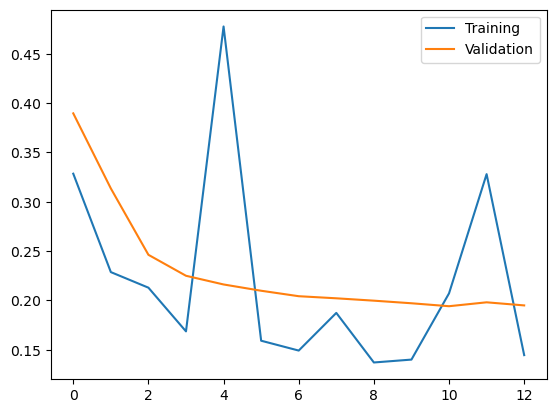

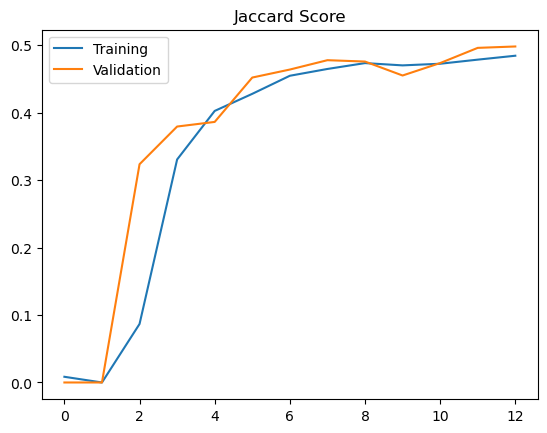

Epoch [14/1000], Loss: 0.2325, Val Loss: 0.1974


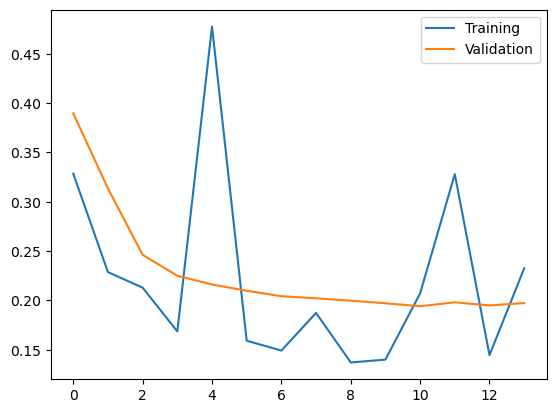

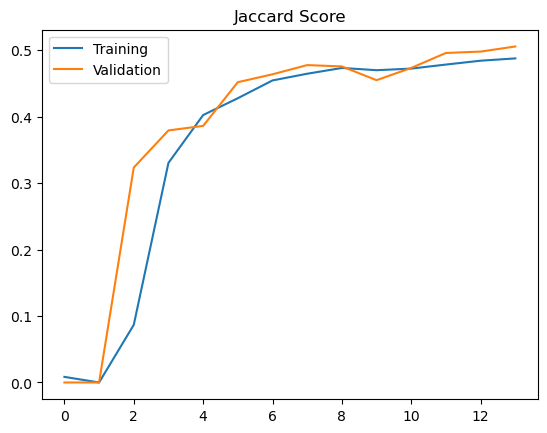

Epoch [15/1000], Loss: 0.1965, Val Loss: 0.1908


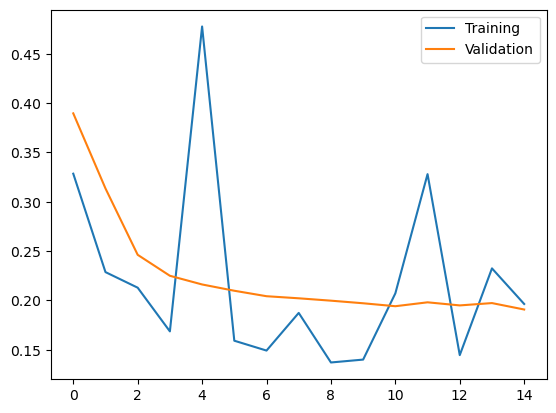

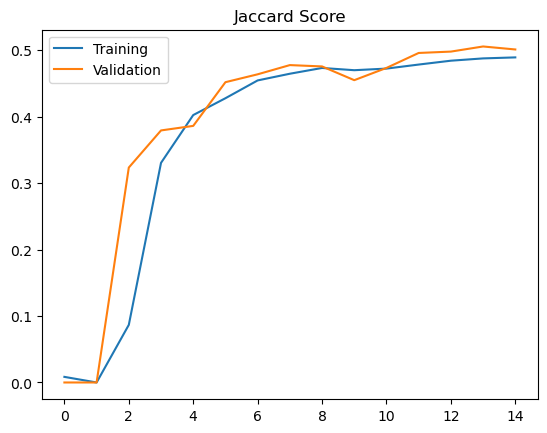

Epoch [16/1000], Loss: 0.1811, Val Loss: 0.1919


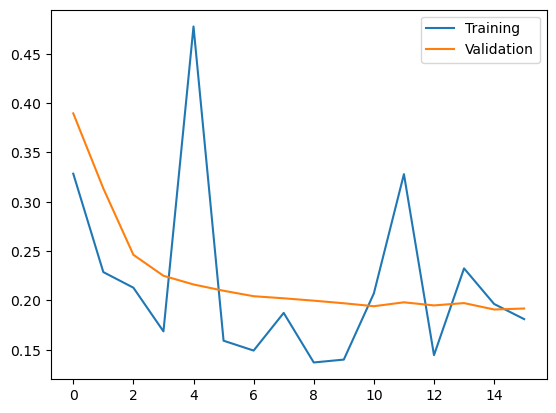

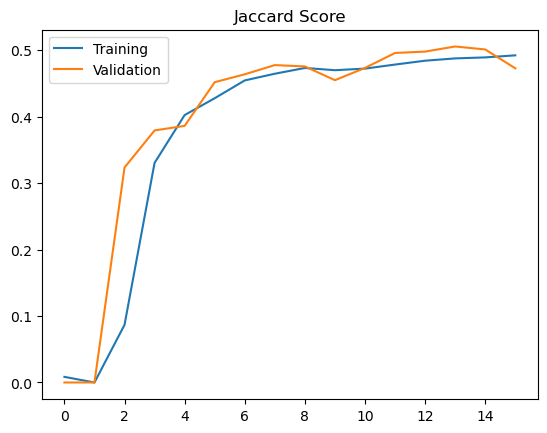

Epoch [17/1000], Loss: 0.1669, Val Loss: 0.1877


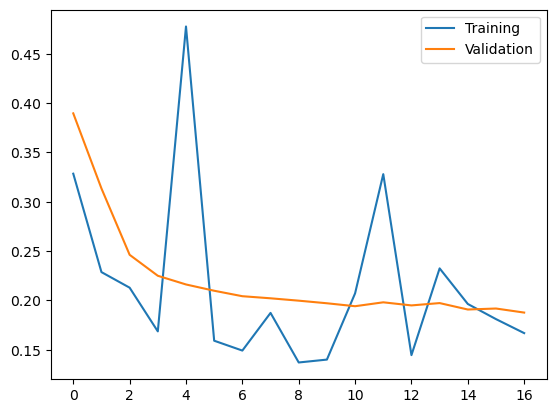

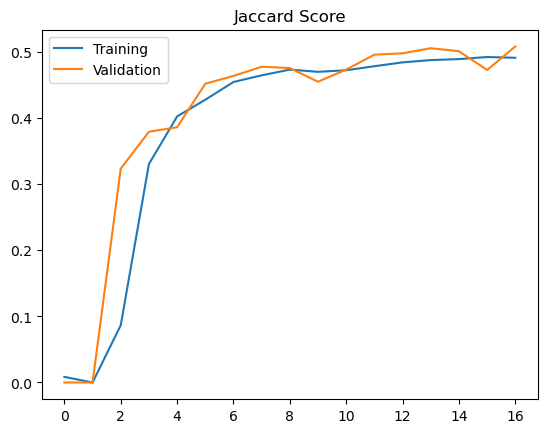

Epoch [18/1000], Loss: 0.1140, Val Loss: 0.1865


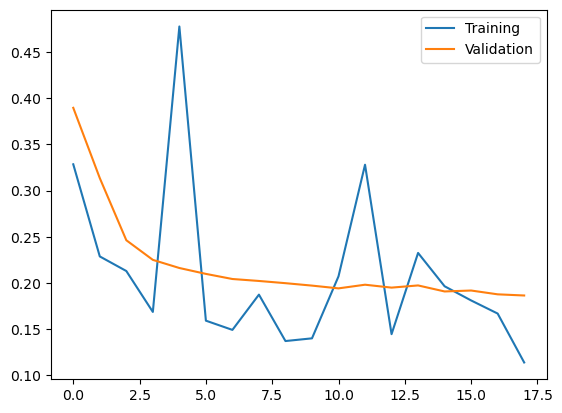

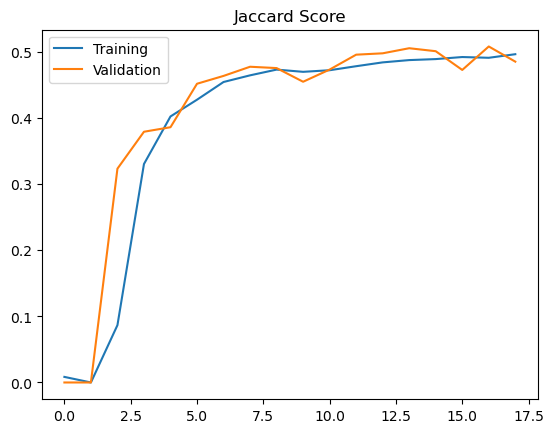

Epoch [19/1000], Loss: 0.0944, Val Loss: 0.1845


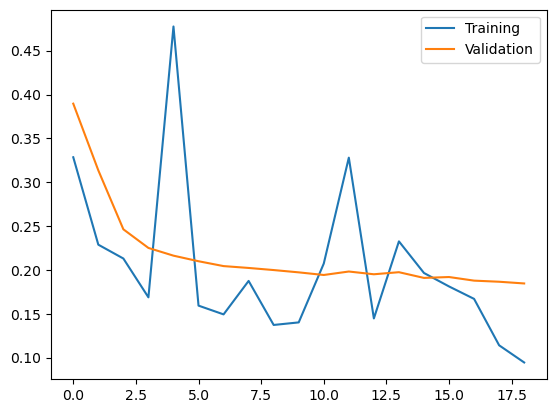

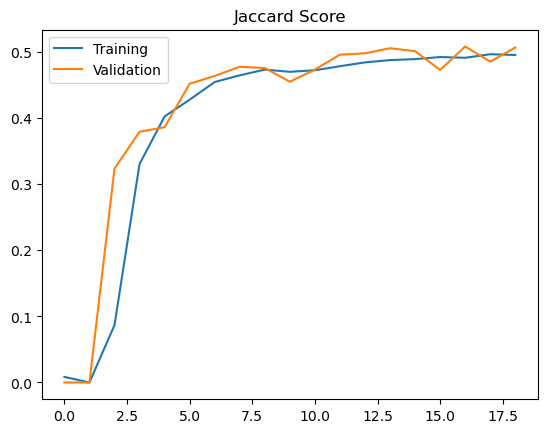

Epoch [20/1000], Loss: 0.7139, Val Loss: 0.1845


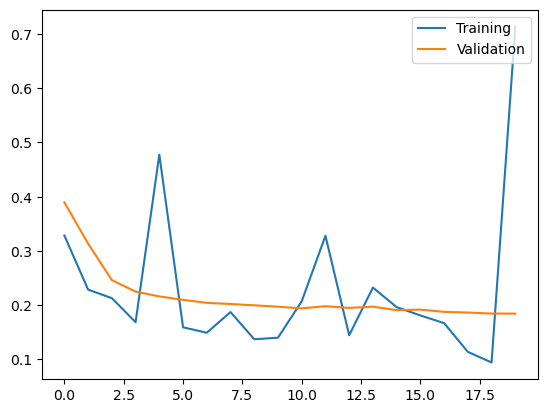

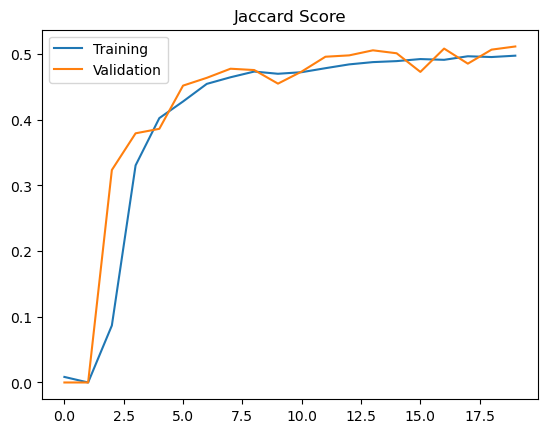

Epoch [21/1000], Loss: 0.2223, Val Loss: 0.1827


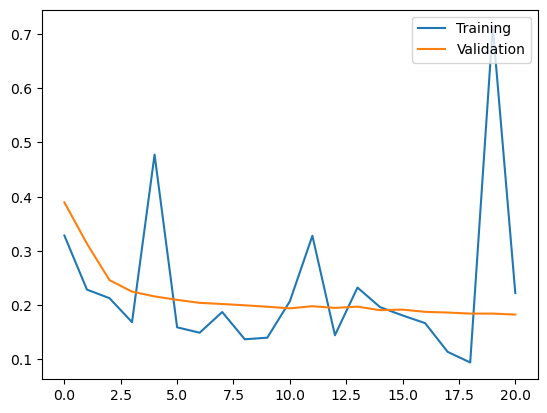

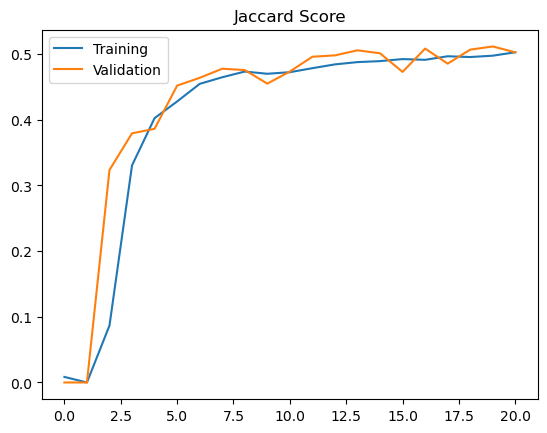

Epoch [22/1000], Loss: 0.2101, Val Loss: 0.1822


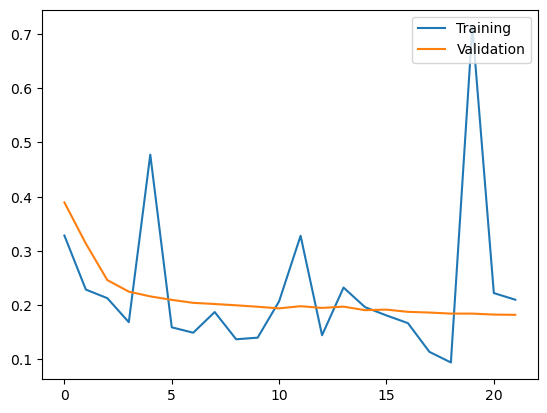

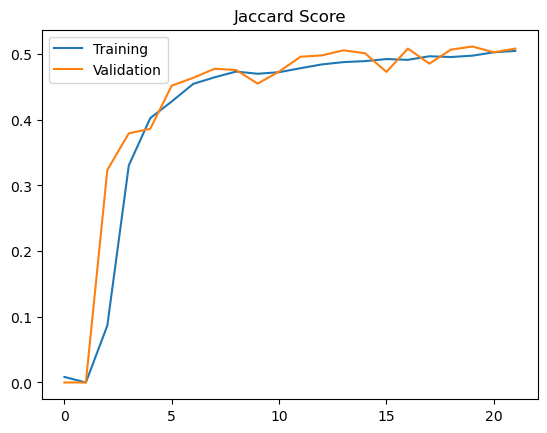

Epoch [23/1000], Loss: 0.1694, Val Loss: 0.1809


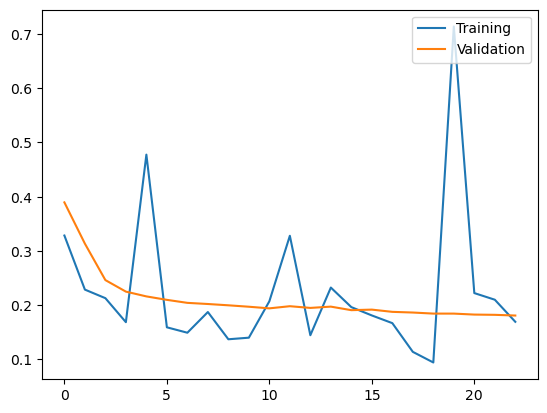

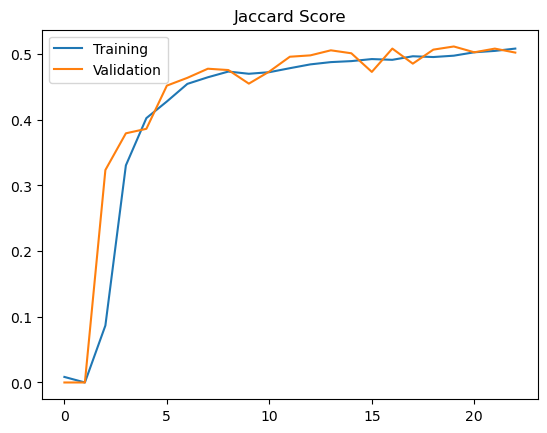

Epoch [24/1000], Loss: 0.1310, Val Loss: 0.1836


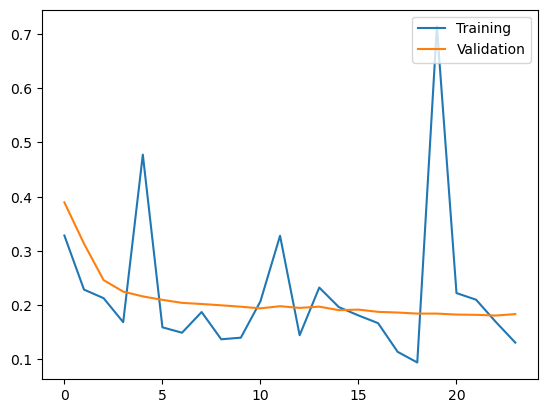

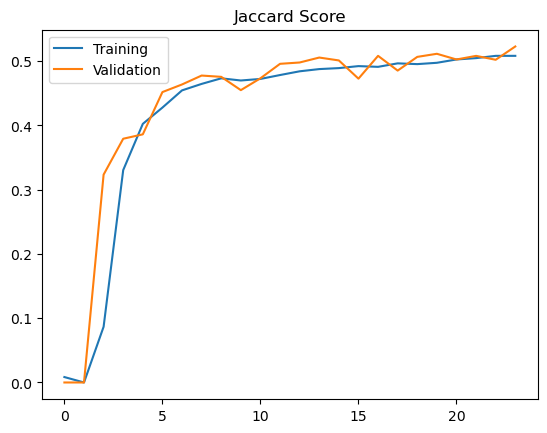

Epoch [25/1000], Loss: 0.2766, Val Loss: 0.1815


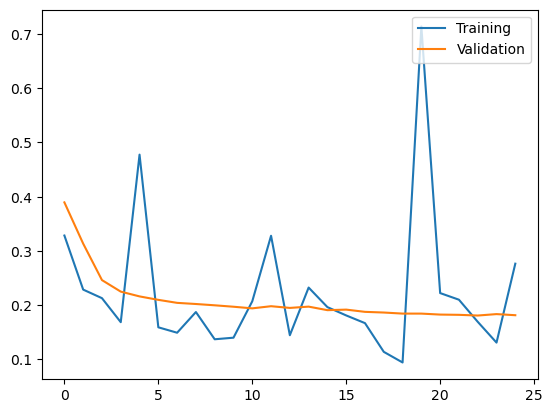

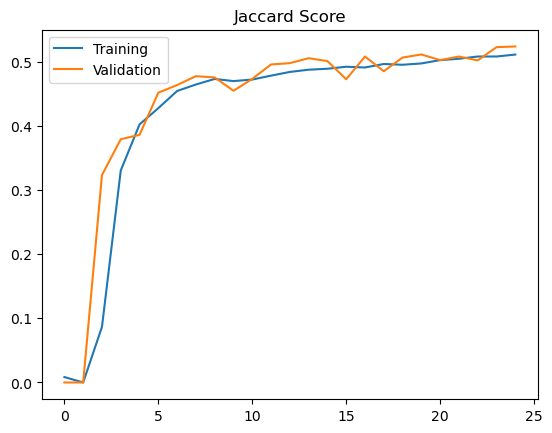

Epoch [26/1000], Loss: 0.1436, Val Loss: 0.1796


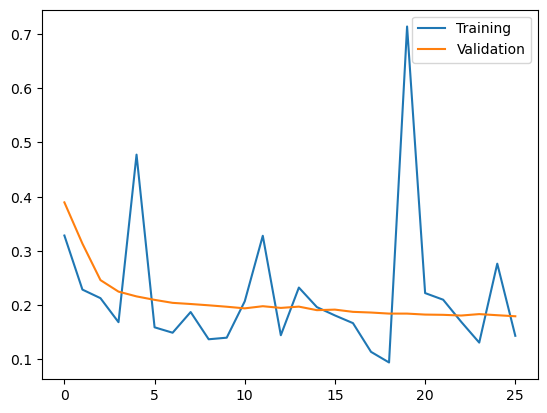

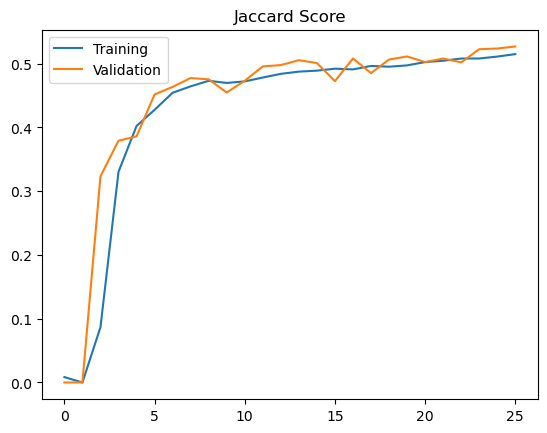

Epoch [27/1000], Loss: 0.4327, Val Loss: 0.1776


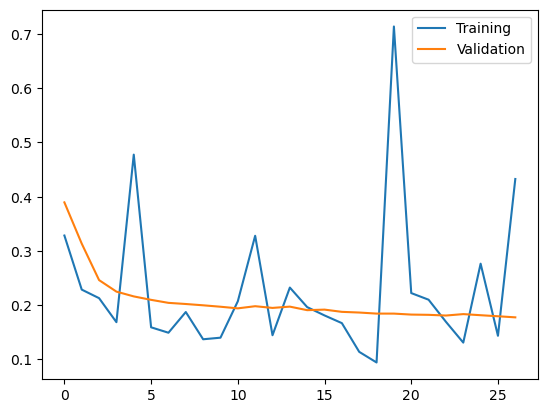

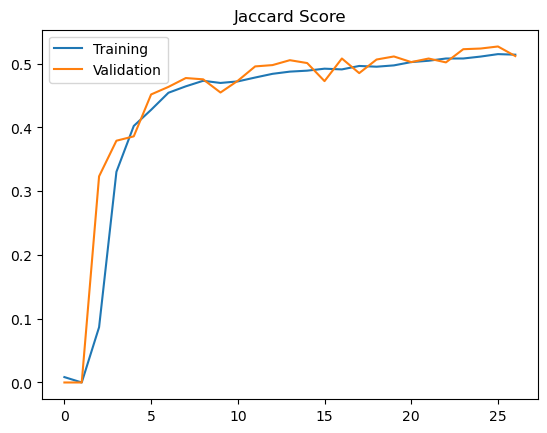

Epoch [28/1000], Loss: 0.1048, Val Loss: 0.1803


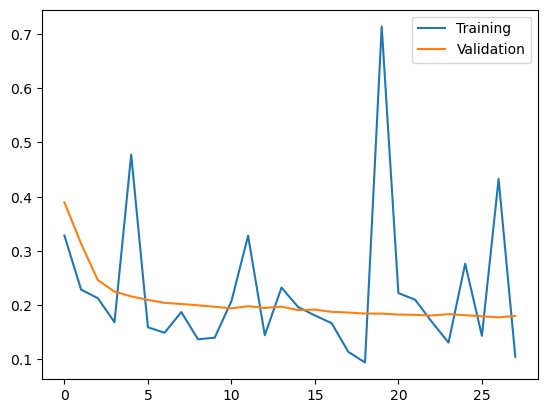

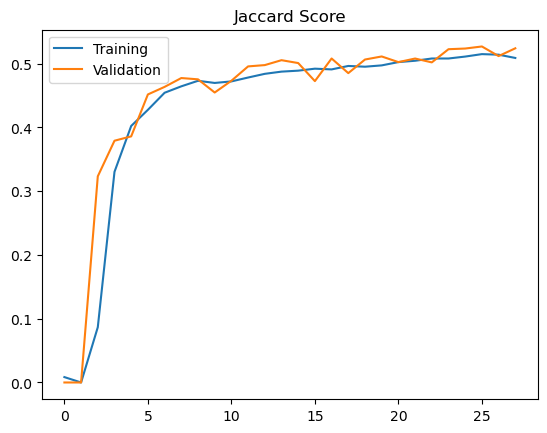

Epoch [29/1000], Loss: 0.1019, Val Loss: 0.1765


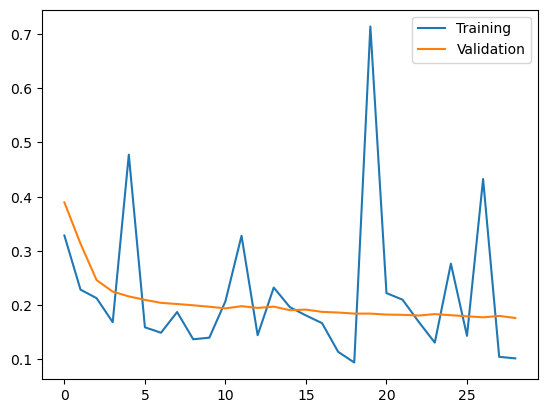

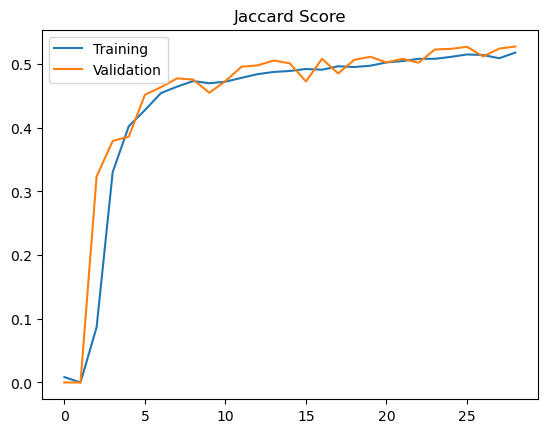

Epoch [30/1000], Loss: 0.2510, Val Loss: 0.1750


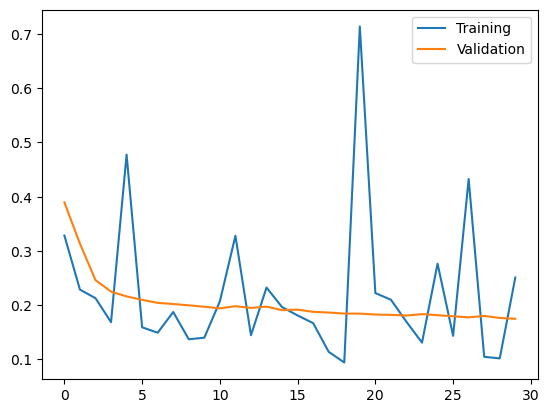

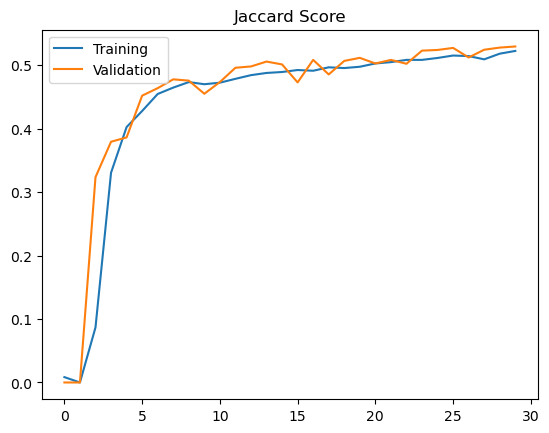

Epoch [31/1000], Loss: 0.4290, Val Loss: 0.1773


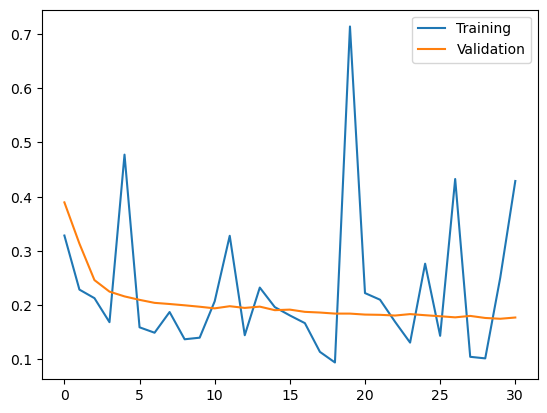

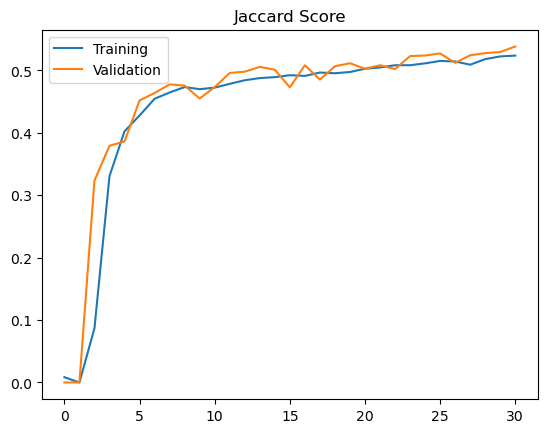

Epoch [32/1000], Loss: 0.0942, Val Loss: 0.1746


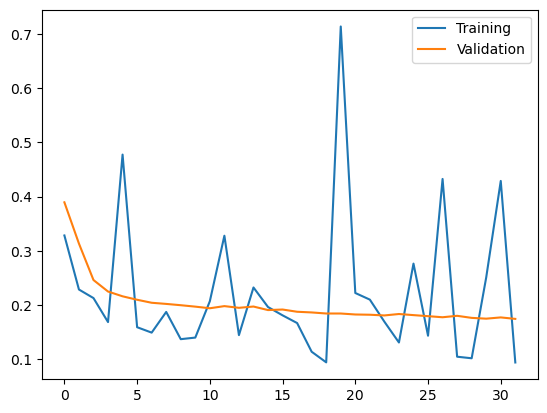

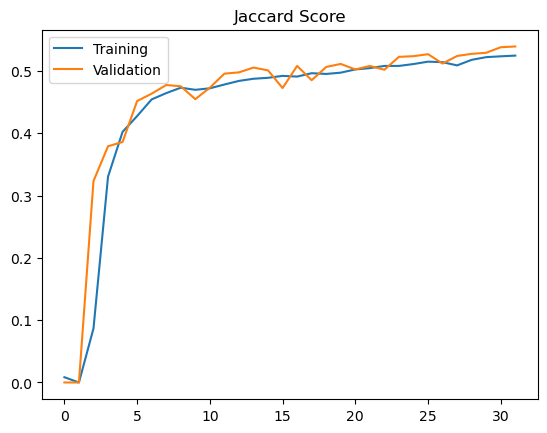

Epoch [33/1000], Loss: 0.2524, Val Loss: 0.1728


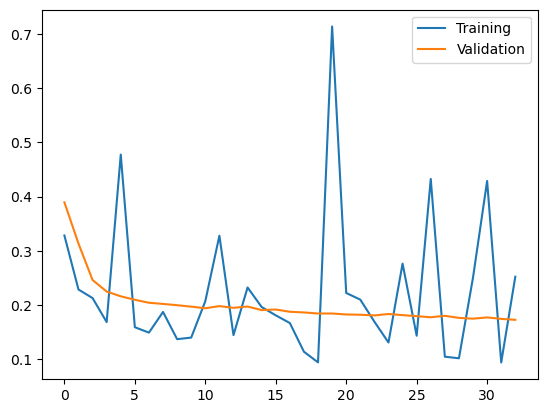

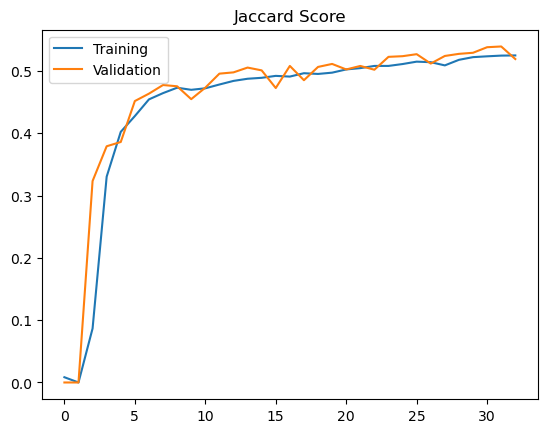

Epoch [34/1000], Loss: 0.0921, Val Loss: 0.1732


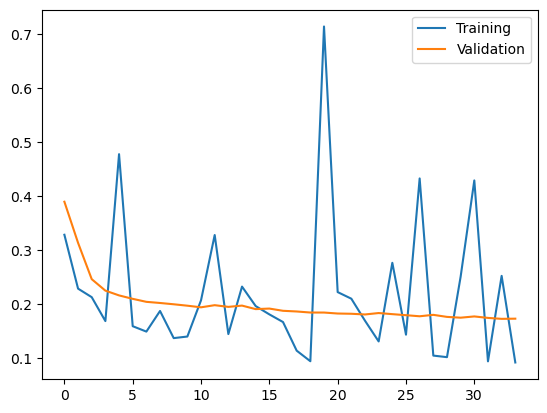

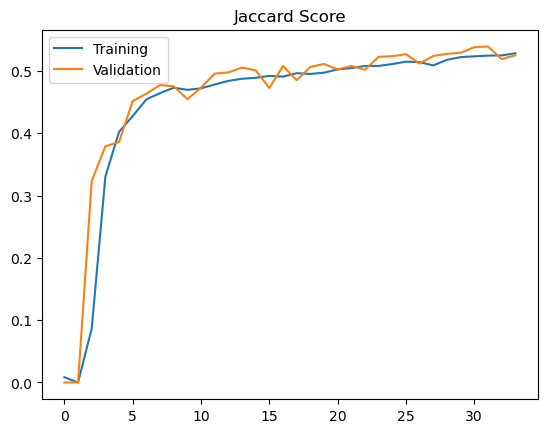

Epoch [35/1000], Loss: 0.0981, Val Loss: 0.1779


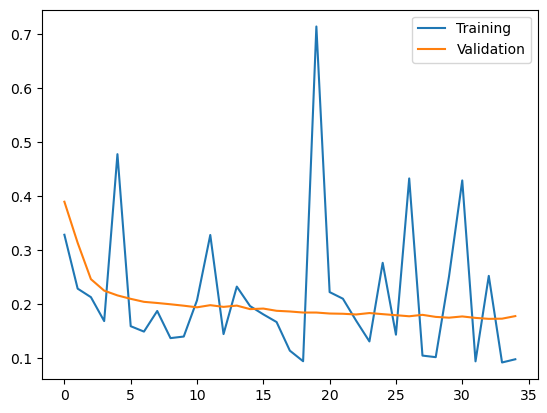

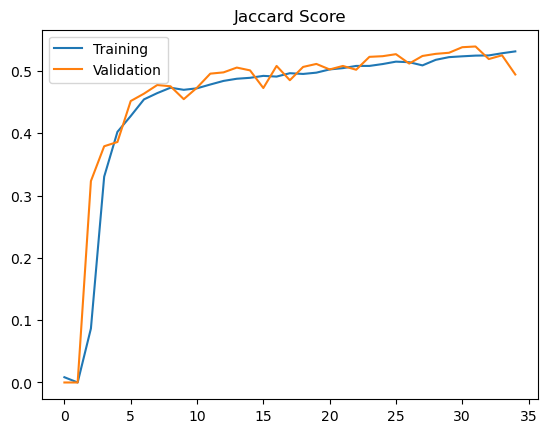

Epoch [36/1000], Loss: 0.1042, Val Loss: 0.1731


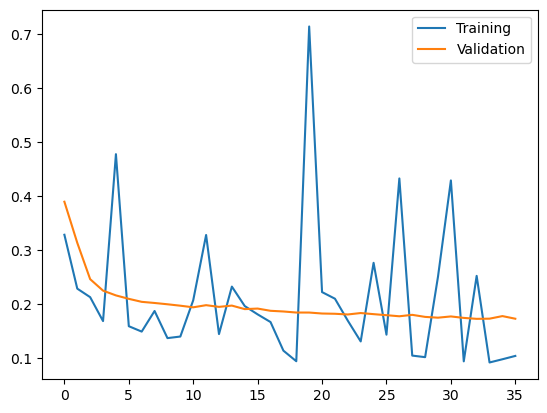

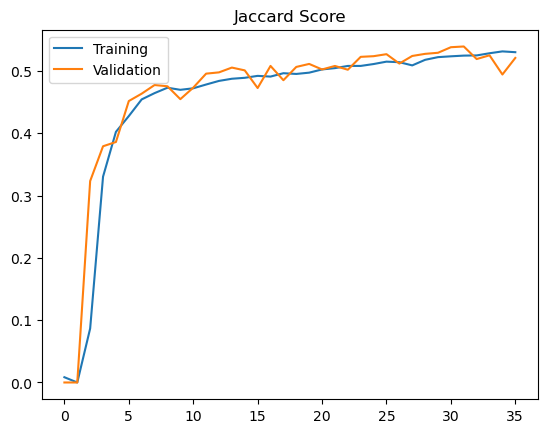

Epoch [37/1000], Loss: 0.1907, Val Loss: 0.1765


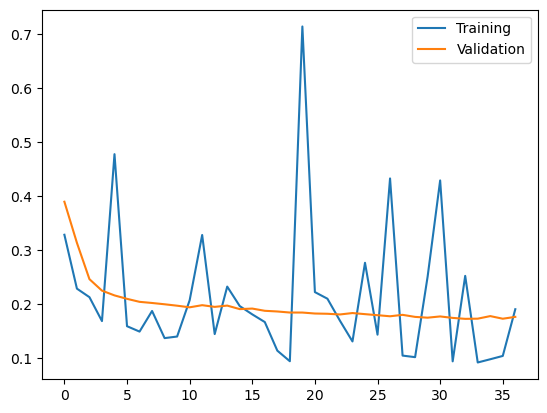

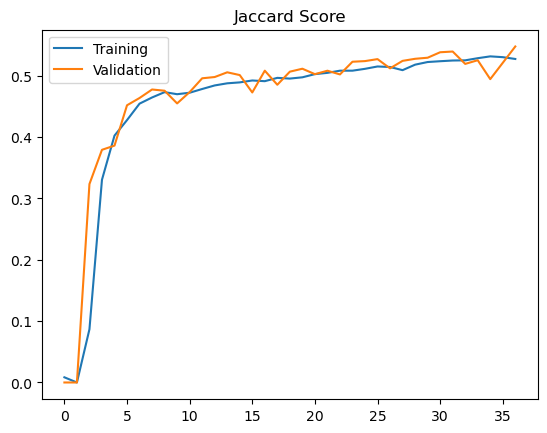

Epoch [38/1000], Loss: 0.1915, Val Loss: 0.1705


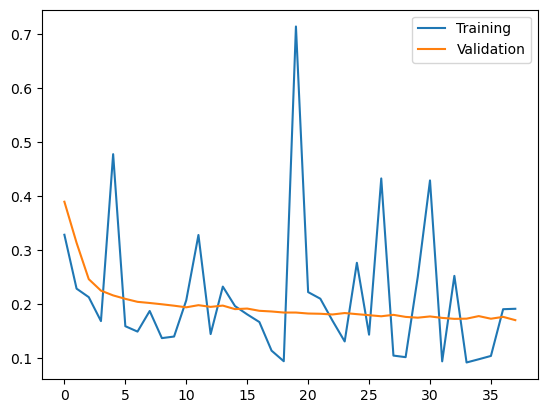

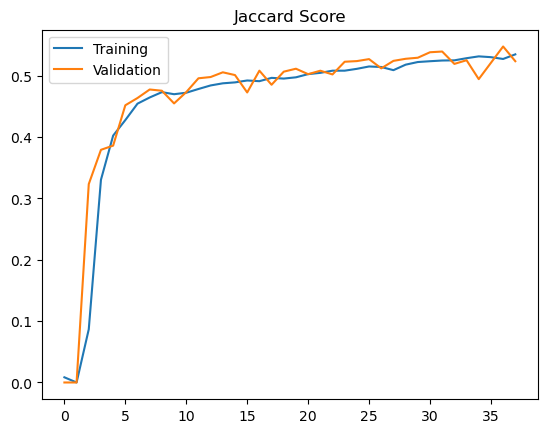

Epoch [39/1000], Loss: 0.1580, Val Loss: 0.1721


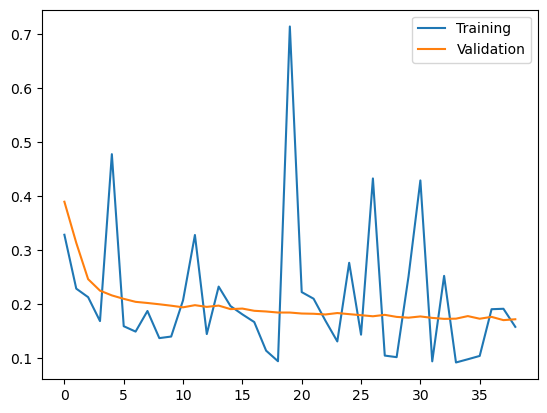

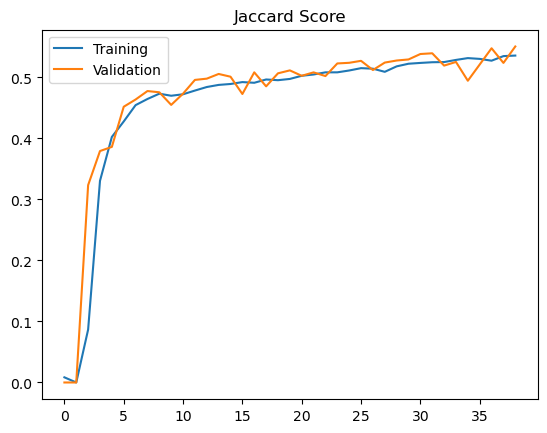

Epoch [40/1000], Loss: 0.4041, Val Loss: 0.1692


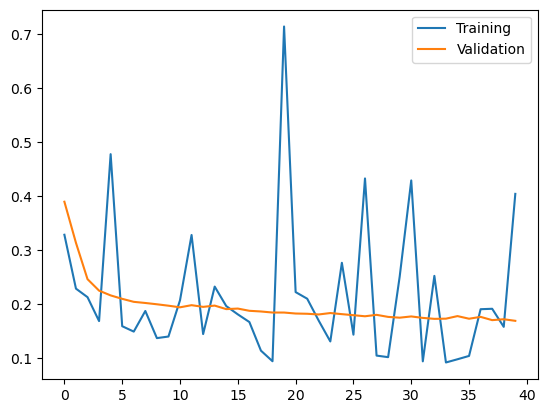

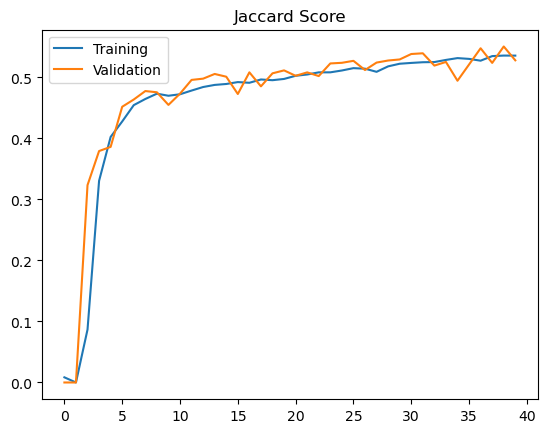

Epoch [41/1000], Loss: 0.0942, Val Loss: 0.1708


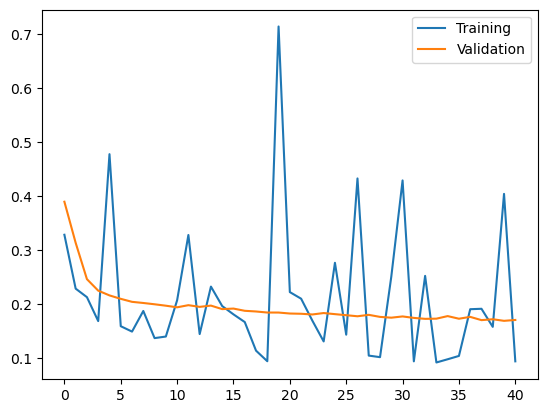

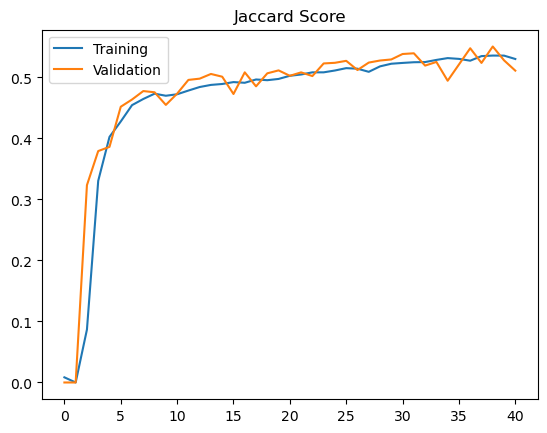

Epoch [42/1000], Loss: 0.1195, Val Loss: 0.1682


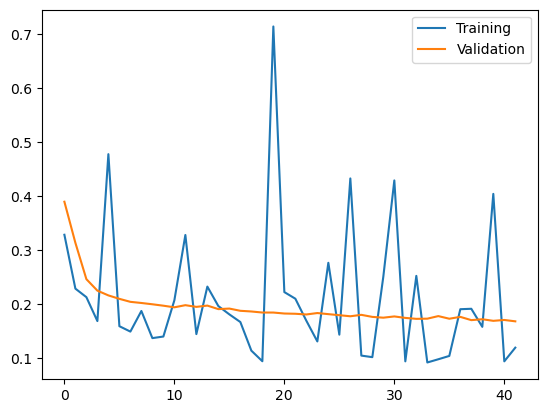

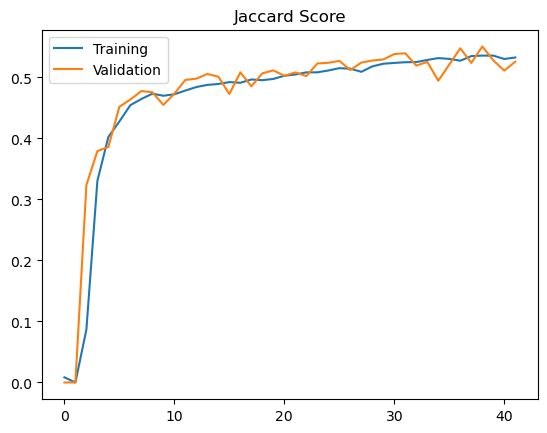

Epoch [43/1000], Loss: 0.1737, Val Loss: 0.1680


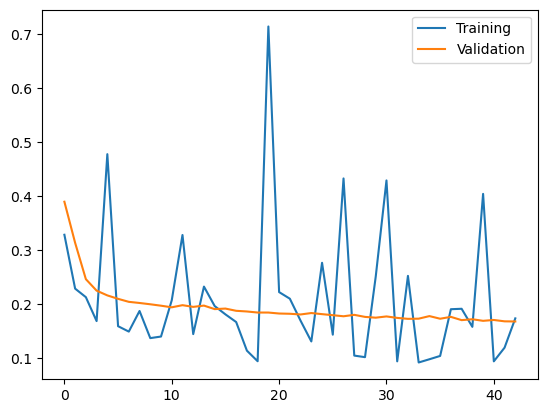

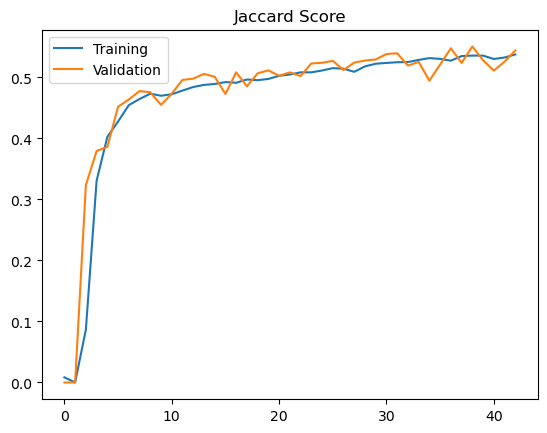

Epoch [44/1000], Loss: 0.2100, Val Loss: 0.1679


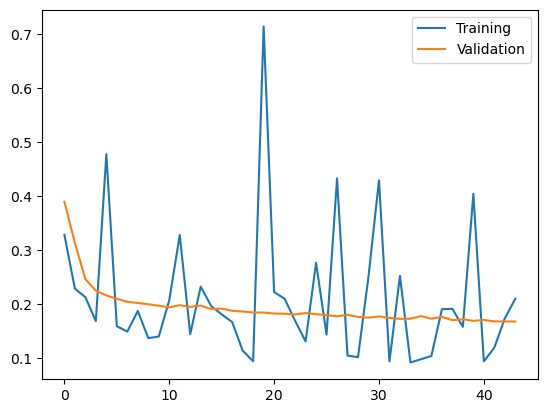

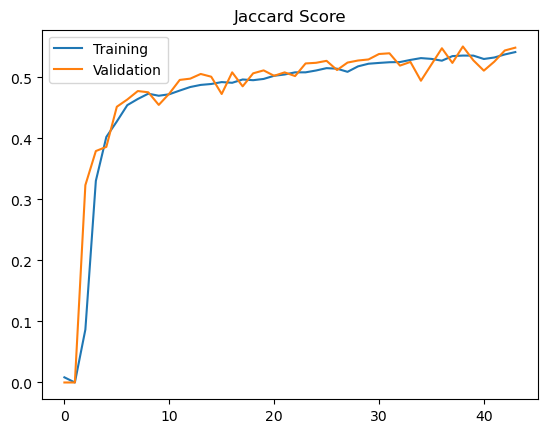

Epoch [45/1000], Loss: 0.1037, Val Loss: 0.1680


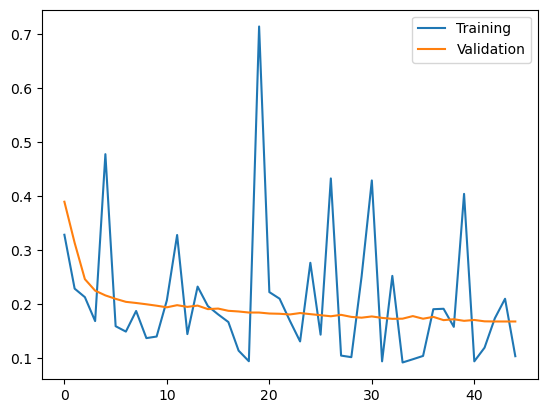

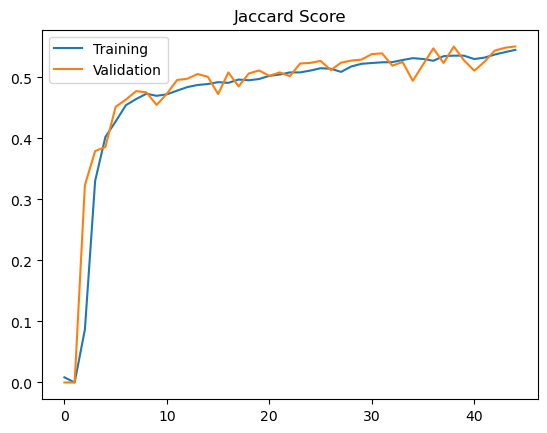

Epoch [46/1000], Loss: 0.1536, Val Loss: 0.1709


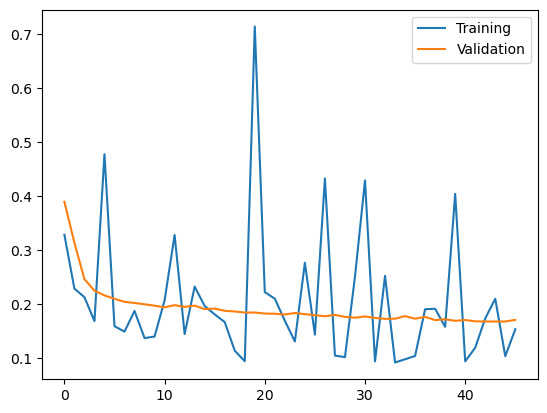

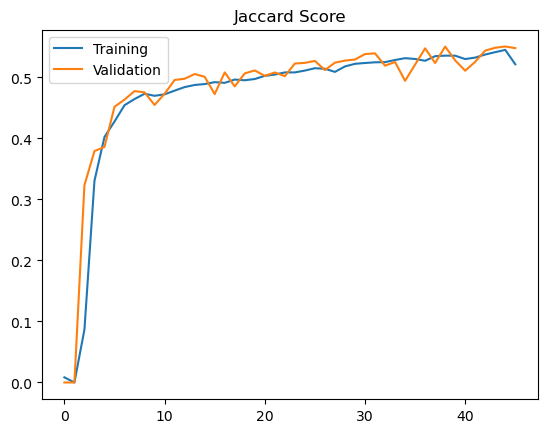

Epoch [47/1000], Loss: 0.1059, Val Loss: 0.1683


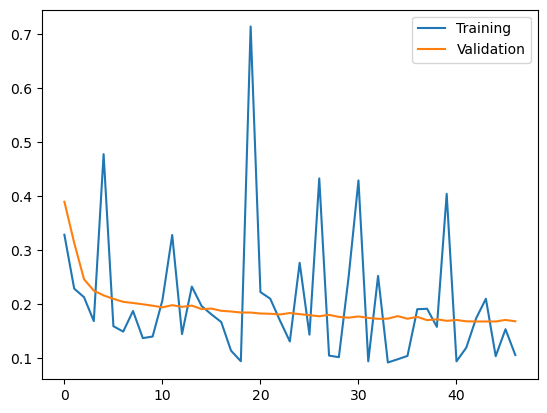

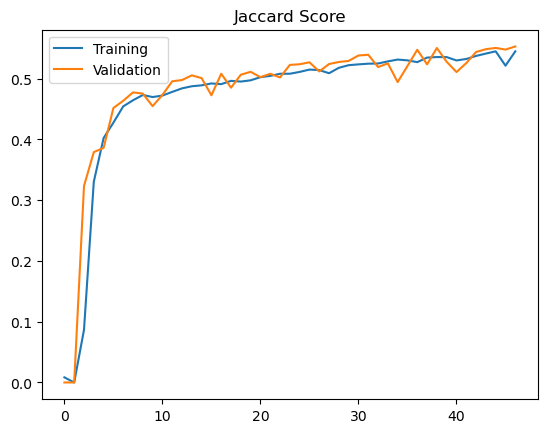

Epoch [48/1000], Loss: 0.1341, Val Loss: 0.1773


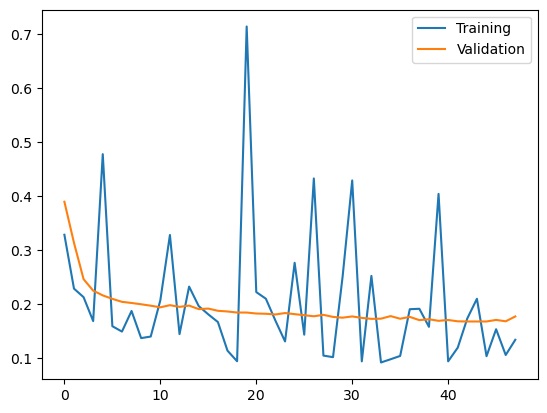

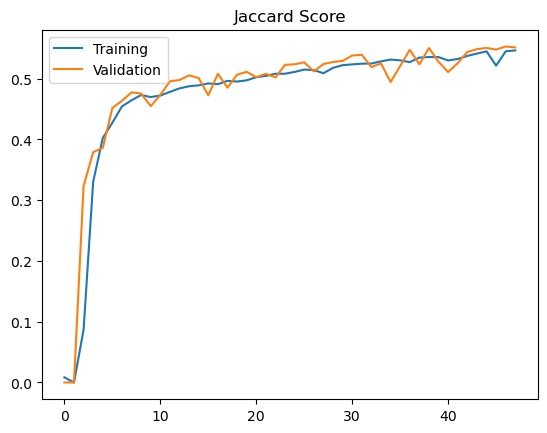

Epoch [49/1000], Loss: 0.1002, Val Loss: 0.1666


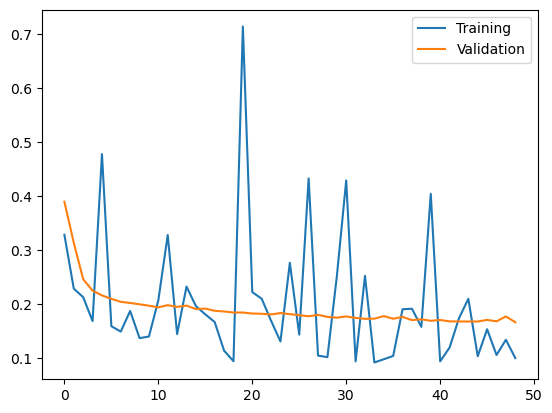

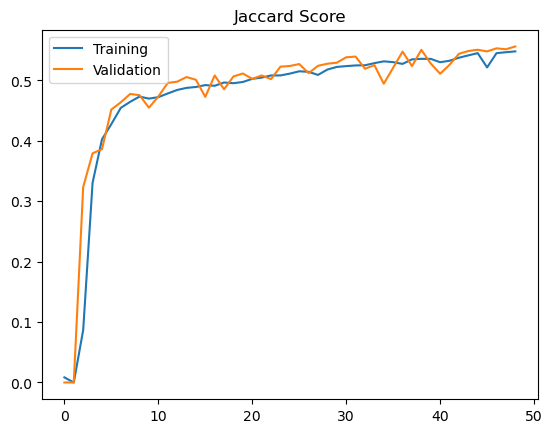

Epoch [50/1000], Loss: 0.1854, Val Loss: 0.1662


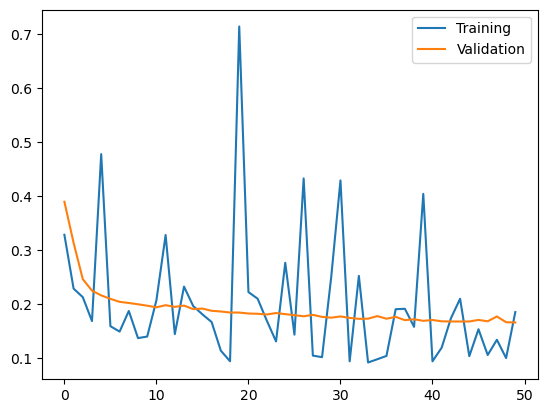

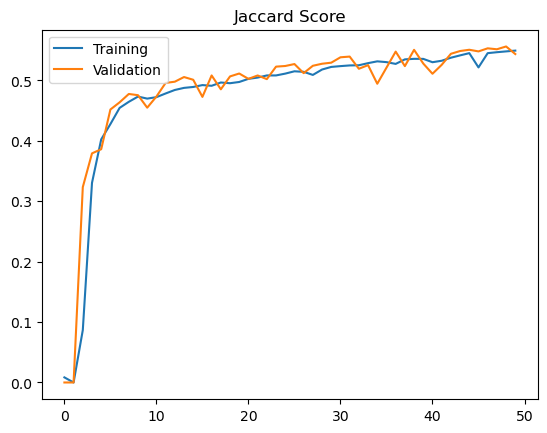

saving model
Epoch [51/1000], Loss: 0.1419, Val Loss: 0.1648


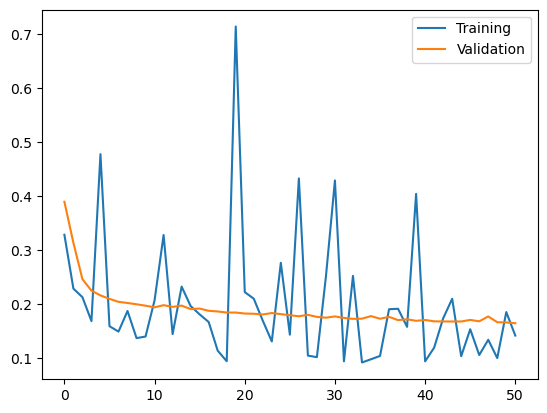

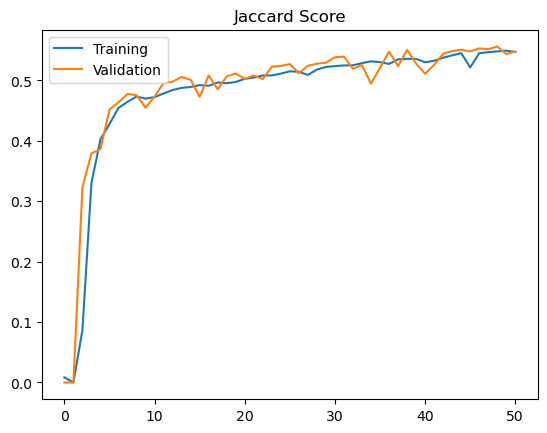

Epoch [52/1000], Loss: 0.4004, Val Loss: 0.1651


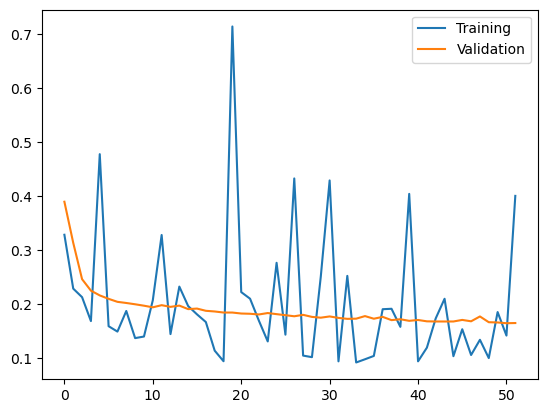

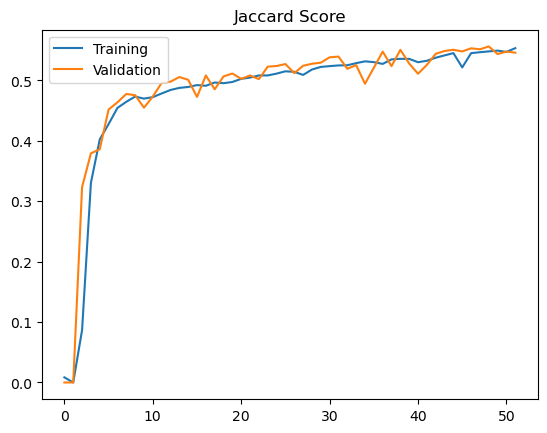

Epoch [53/1000], Loss: 0.2539, Val Loss: 0.1645


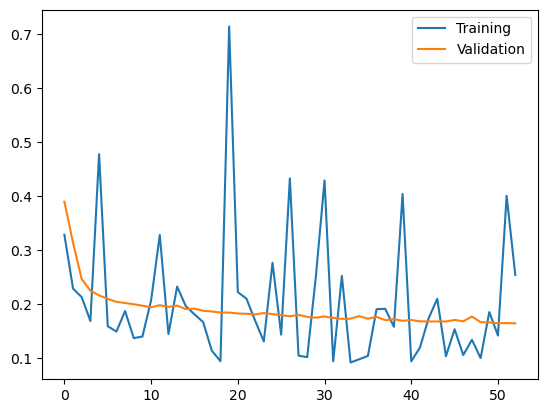

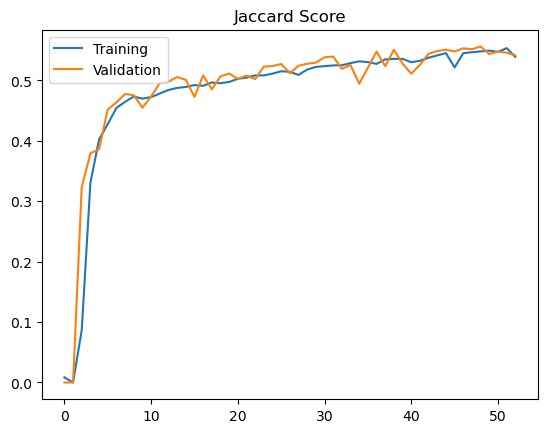

Epoch [54/1000], Loss: 0.1855, Val Loss: 0.1646


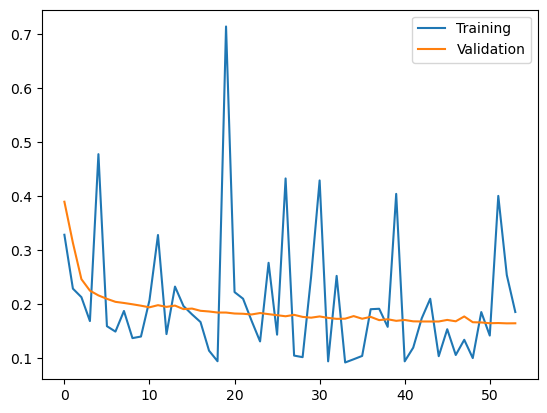

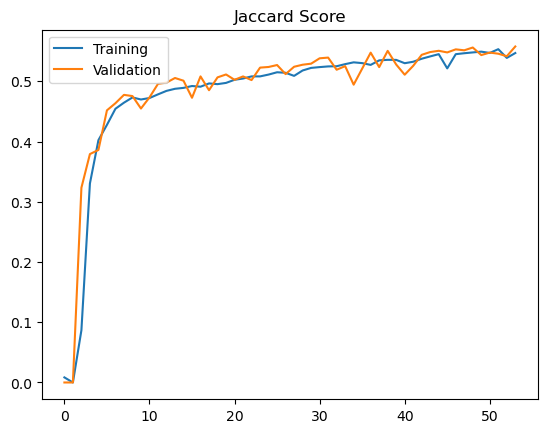

Epoch [55/1000], Loss: 0.1980, Val Loss: 0.1670


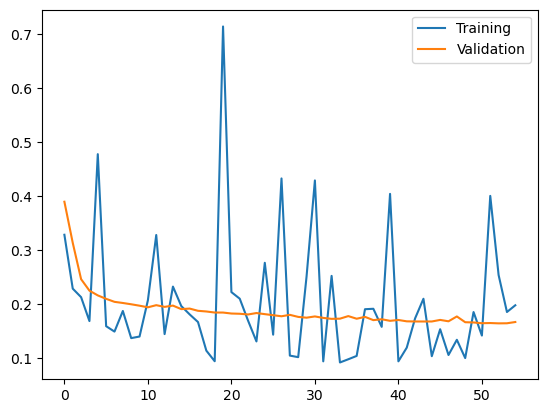

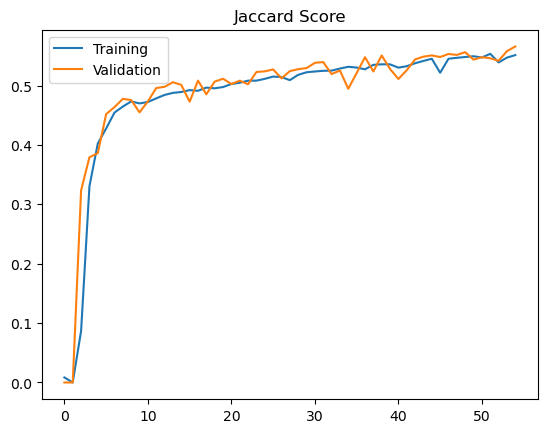

Epoch [56/1000], Loss: 0.1628, Val Loss: 0.1628


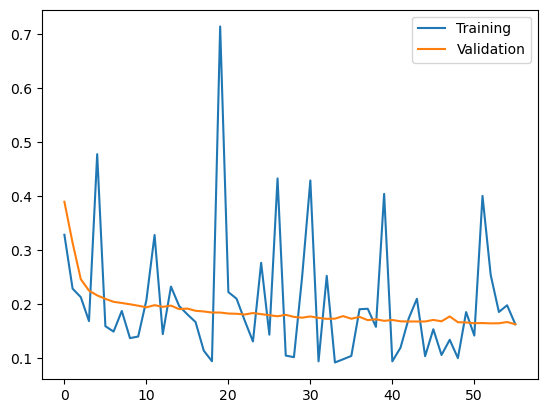

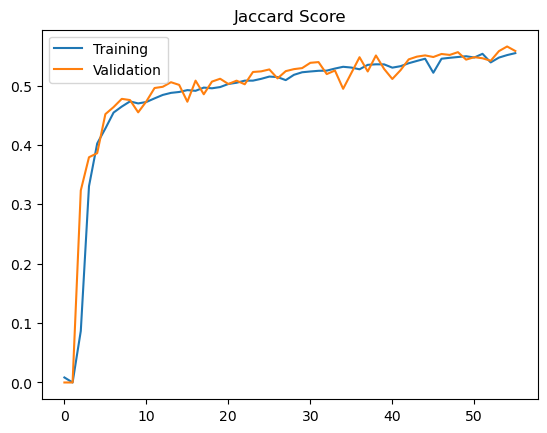

Epoch [57/1000], Loss: 0.1086, Val Loss: 0.1615


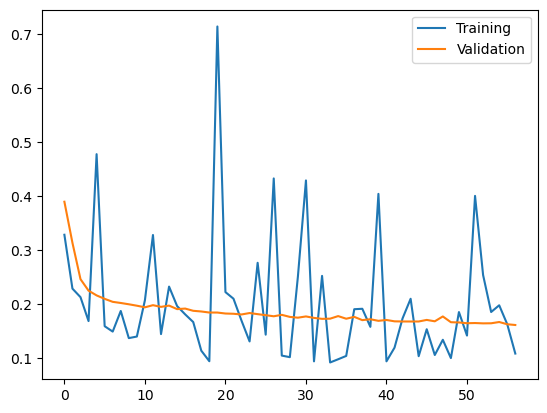

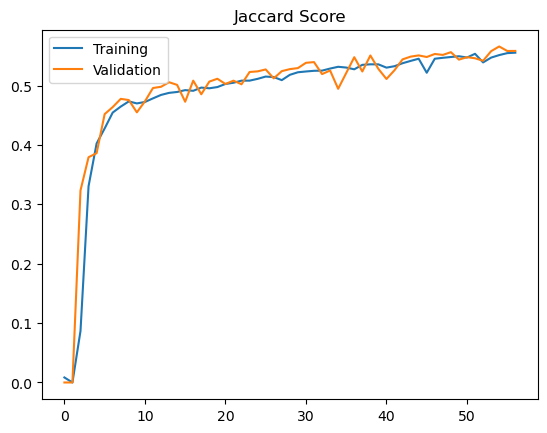

Epoch [58/1000], Loss: 0.1468, Val Loss: 0.1646


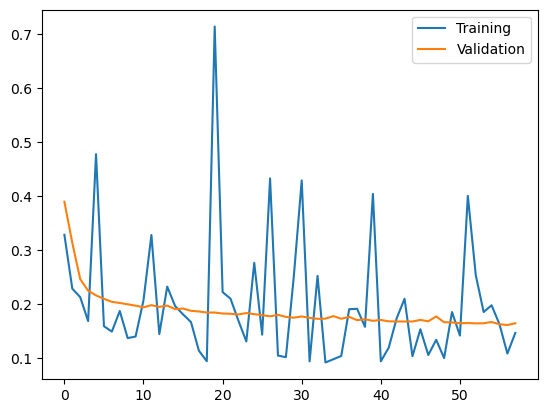

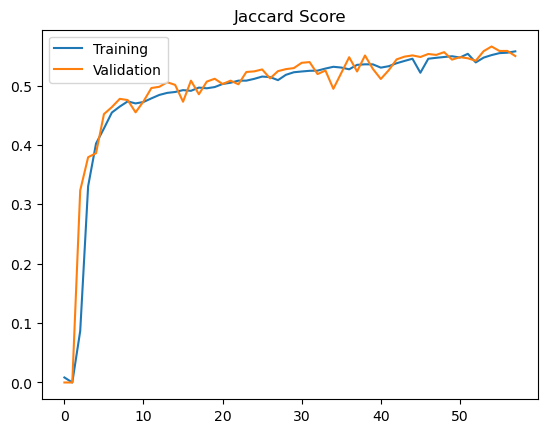

Epoch [59/1000], Loss: 0.2263, Val Loss: 0.1626


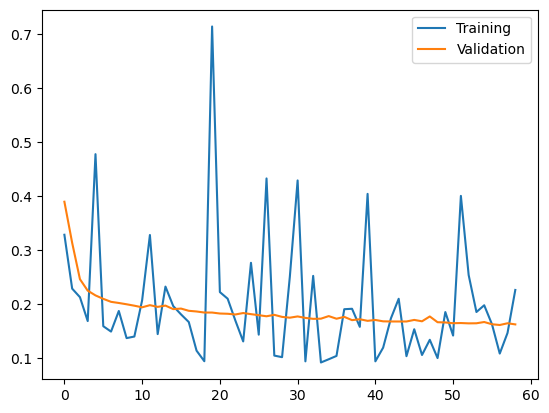

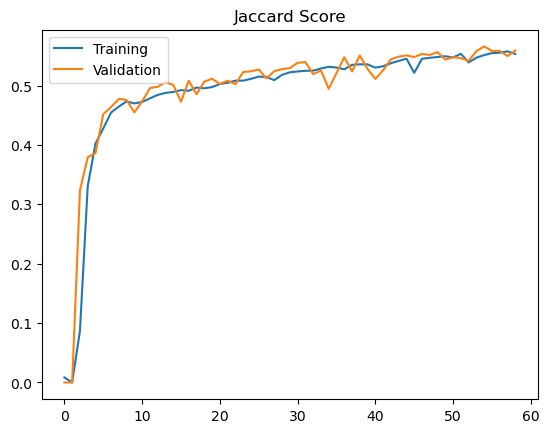

Epoch [60/1000], Loss: 0.0879, Val Loss: 0.1623


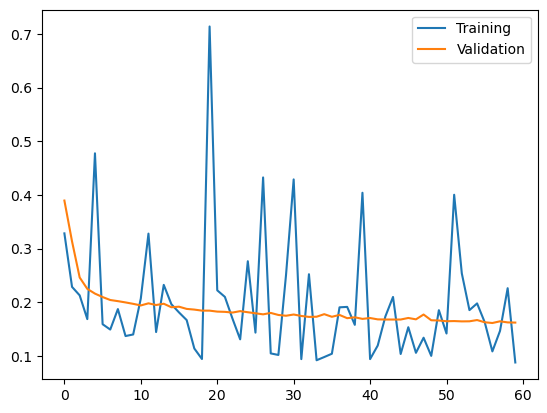

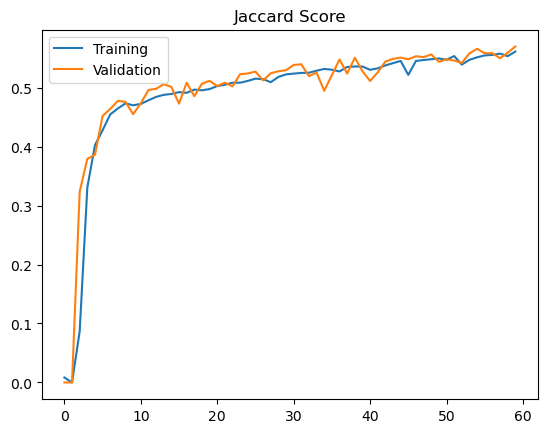

Epoch [61/1000], Loss: 0.1003, Val Loss: 0.1613


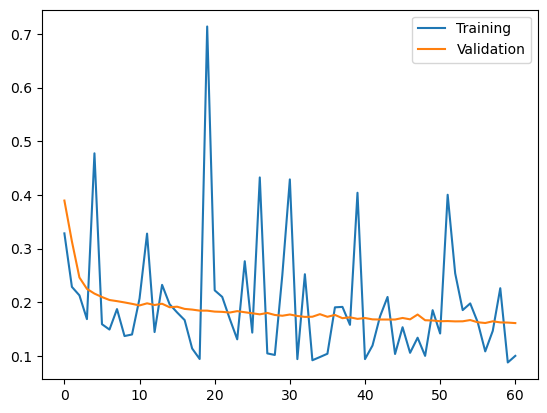

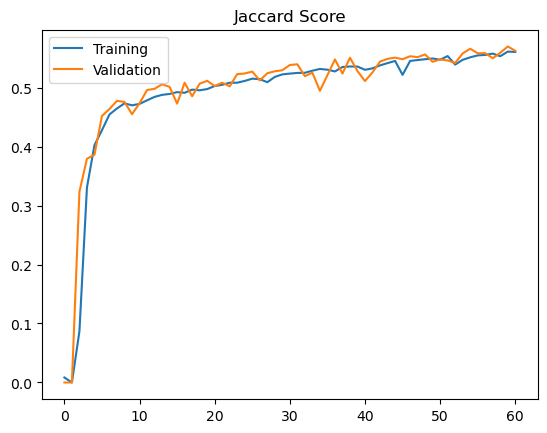

Epoch [62/1000], Loss: 0.1039, Val Loss: 0.1641


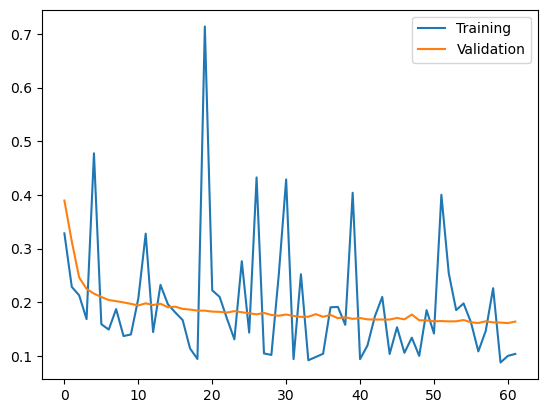

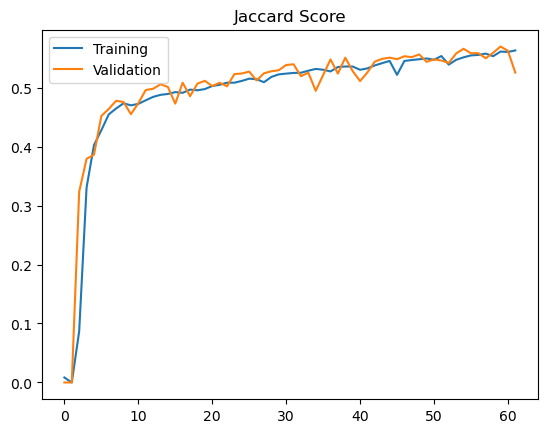

Epoch [63/1000], Loss: 0.0846, Val Loss: 0.1622


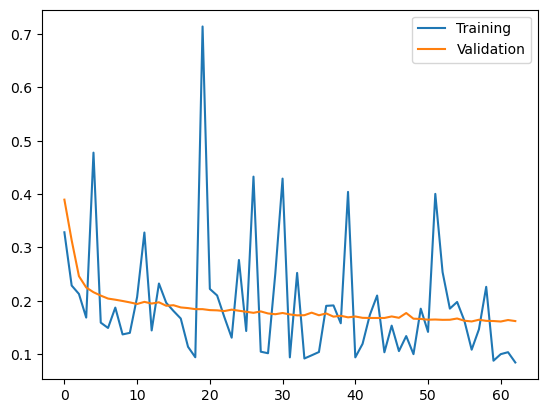

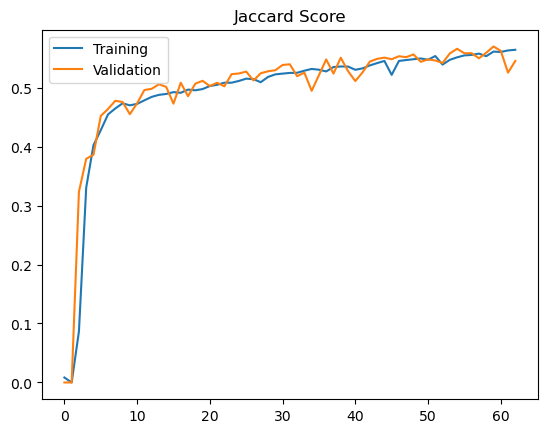

Epoch [64/1000], Loss: 0.0918, Val Loss: 0.1625


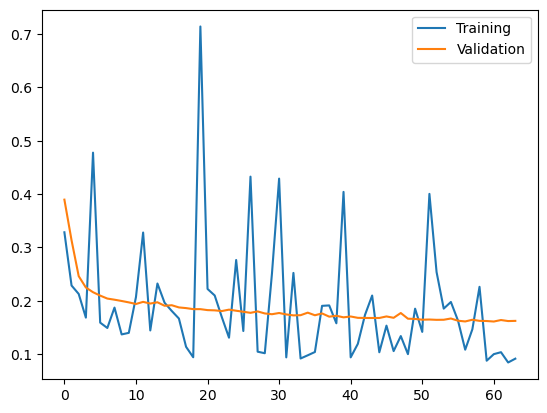

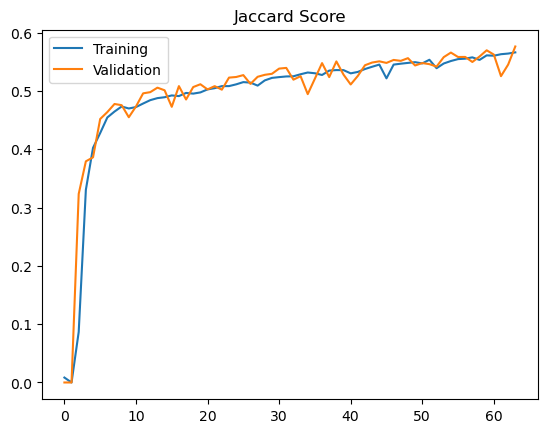

Epoch [65/1000], Loss: 0.1260, Val Loss: 0.1634


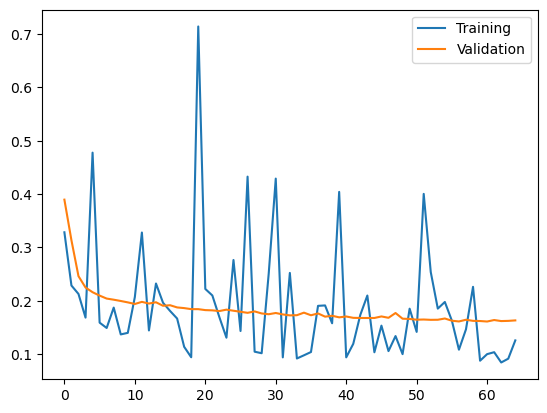

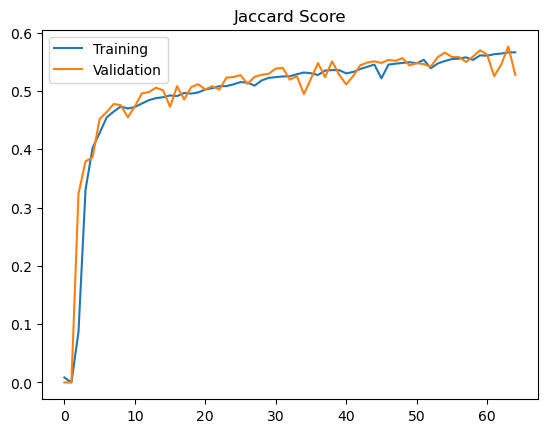

Epoch [66/1000], Loss: 0.2594, Val Loss: 0.1591


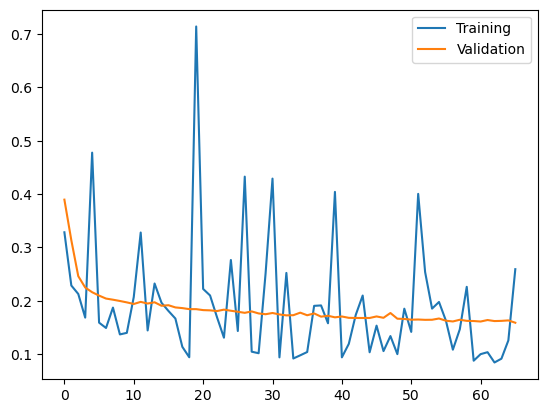

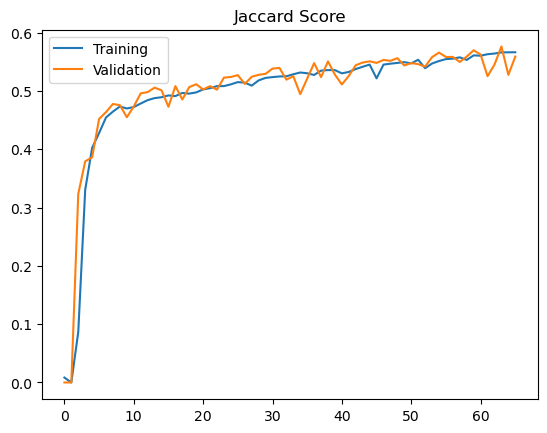

Epoch [67/1000], Loss: 0.1329, Val Loss: 0.1617


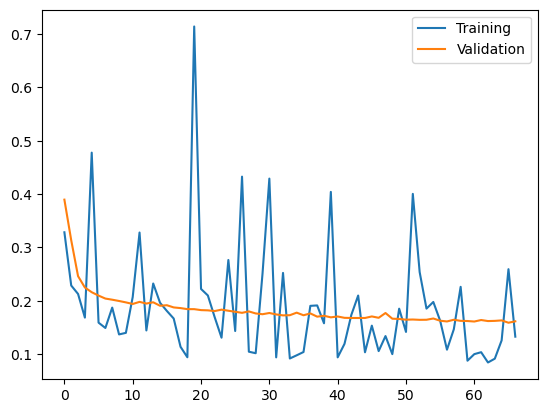

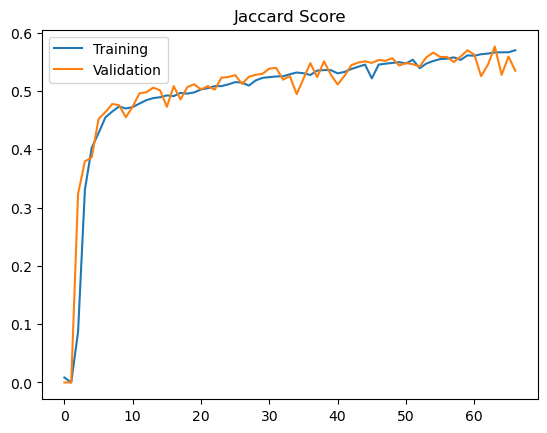

Epoch [68/1000], Loss: 0.1035, Val Loss: 0.1597


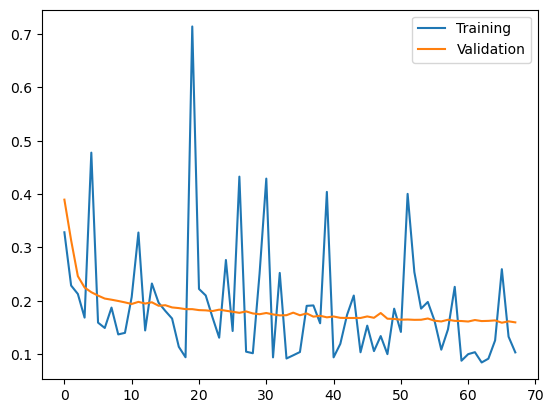

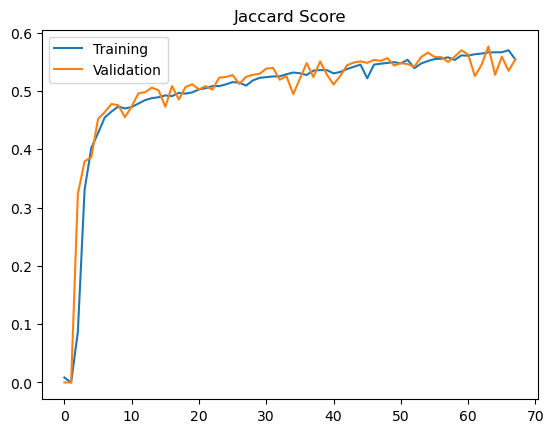

Epoch [69/1000], Loss: 0.1088, Val Loss: 0.1587


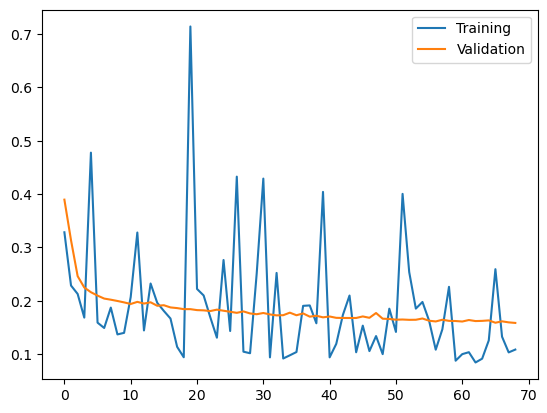

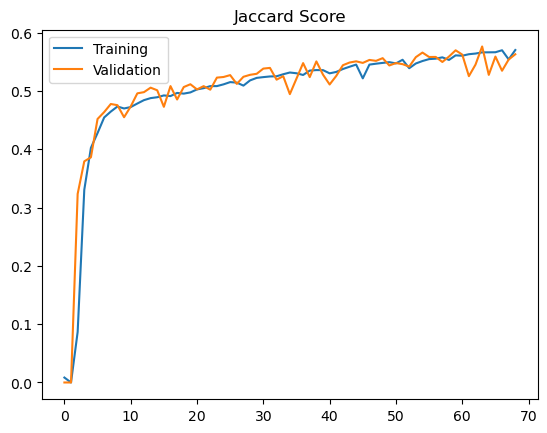

Epoch [70/1000], Loss: 0.0752, Val Loss: 0.1591


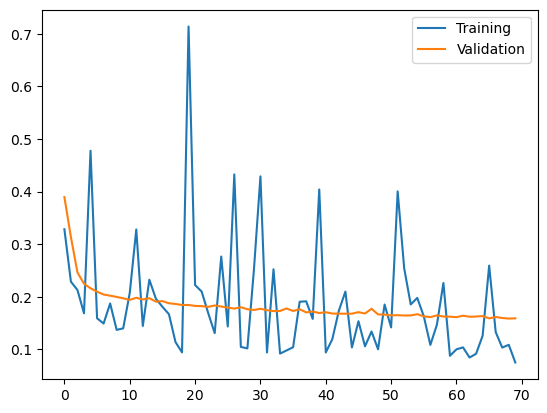

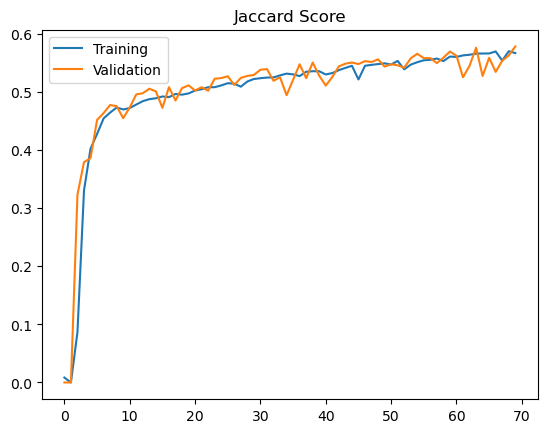

Epoch [71/1000], Loss: 0.1048, Val Loss: 0.1608


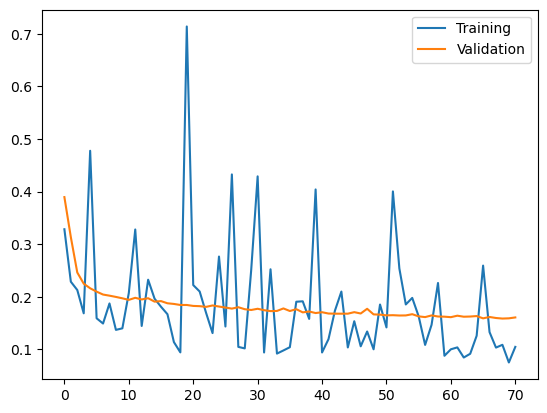

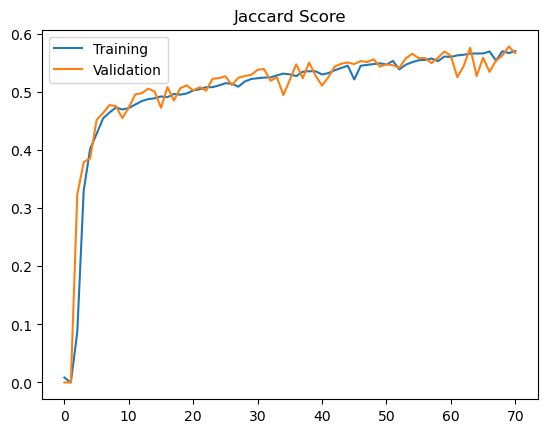

Epoch [72/1000], Loss: 0.1211, Val Loss: 0.1583


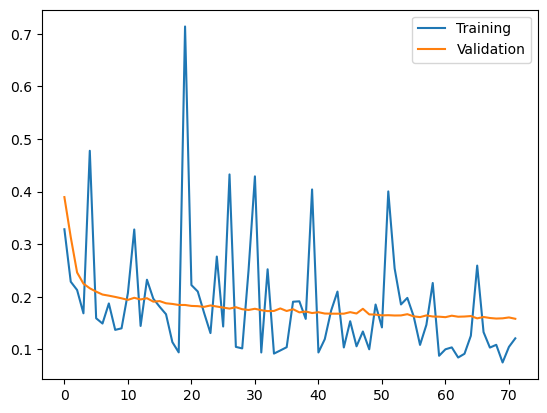

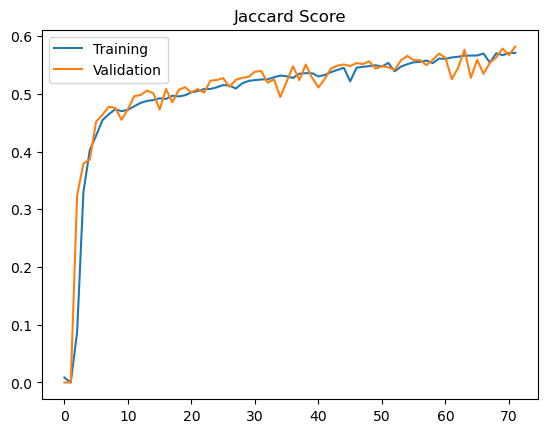

RuntimeError: MPS backend out of memory (MPS allocated: 1.58 GB, other allocations: 7.46 GB, max allowed: 9.07 GB). Tried to allocate 20.25 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [32]:
import os

# Check if a pre-saved model exists
pretrained_model_path = './trained_model_e_350_checkpoint.pth'
if os.path.exists(pretrained_model_path):
    print("there si my boy")
    # Instantiate the model
    model = CNN()
    model.load_state_dict(torch.load(pretrained_model_path))
    model.to(mps_device)
else:
    # Instantiate a new model
    model = CNN()
    model.to(mps_device)


# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1000
loss_scores = []
val_loss_scores = []
jacc_scores = []
val_jacc_scores = []
jaccard = JaccardIndex(task='binary').to(mps_device)

for epoch in range(num_epochs):
    model.train()
    jacc_score = 0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        jacc_score += jaccard(outputs, labels.unsqueeze(1))
        
    # Validation loop
    model.eval()
    val_loss = 0
    val_jacc_score = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1) # adding a dimention for the channel
            labels = labels.unsqueeze(1) # adding a dimention for the channel
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Jaccard
            val_jacc_score += jaccard(outputs, labels).cpu()
    
    # jacc_scores.append(jacc_score)
    loss_scores.append(loss.item())
    jacc_scores.append(jacc_score.cpu()/len(train_loader))
    val_loss_scores.append(val_loss/len(val_loader))
    val_jacc_scores.append(val_jacc_score.cpu()/len(val_loader))

    # CHECKPOINT
    if epoch >= 50 and epoch % 50 == 0:
        print("saving model")
        torch.save(model.state_dict(), f'trained_model_e_{epoch}_checkpoint.pth')



    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    # PLOT
    plt.clf()
    plt.plot(loss_scores)
    plt.plot(val_loss_scores)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    plt.plot(jacc_scores)
    plt.plot(val_jacc_scores)
    plt.title('Jaccard Score')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    if epoch < 100:
        continue
    # CHECK LOSS DESCENT
    elif np.sum(val_loss_scores[-50:]) > np.sum(val_loss_scores[-100:-50]):
        print(f"checked {np.sum(val_loss_scores[-20:])} with {np.sum(val_loss_scores[-40:-20])}")
        torch.save(model.state_dict(), f'trained_model_e_{epoch}_critical.pth')
        

torch.save(model.state_dict(), f'trained_model_e:{epoch}_{time.localtime()}.pth')


plt.plot(loss_scores)
plt.plot(val_loss_scores)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(jacc_scores)
plt.plot(val_jacc_scores)
plt.title('Jaccard Score')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


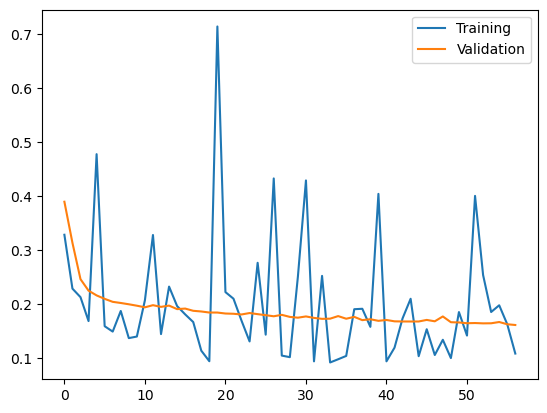

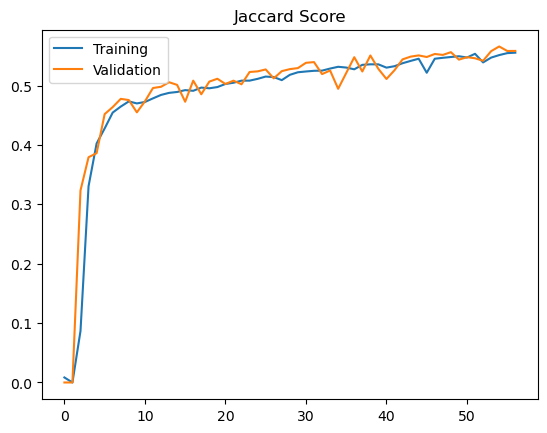

In [ ]:
plt.plot(loss_scores)
plt.plot(val_loss_scores)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(jacc_scores)
plt.plot(val_jacc_scores)
plt.title('Jaccard Score')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(val_loss_scores[-10:])
print(val_loss_scores[-20:-10])

[0.15601262255855228, 0.15425246889176575, 0.1530420533988787, 0.15283736230238623, 0.1533356545412022, 0.15222547980754272, 0.1564594338769498, 0.15499312430620193, 0.15218441998181137, 0.1522929218152295]
[0.154063878176005, 0.15888251914926196, 0.15417979949194452, 0.15414688509443533, 0.15447212172591168, 0.15354504533435986, 0.1557862454134485, 0.15373930432226346, 0.1538104006777639, 0.15303473660479422]


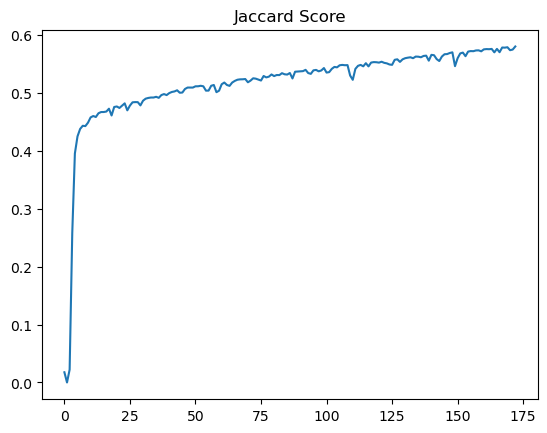

<Figure size 640x480 with 0 Axes>

In [ ]:
# jacc_scores = np.array([score.cpu() for score in jacc_scores])
# val_jacc_scores = [score.cpu() for score in val_jacc_scores]

plt.plot(jacc_scores)
plt.plot(val_jacc_score)
plt.title('Jaccard Score')
plt.show()
plt.tight_layout()

In [ ]:
np.save(f"loss_scores_{time.localtime()}.npy", arr=loss_scores)
np.save(f"val_loss_scores_{time.localtime()}.npy", arr=val_loss_scores)

/Users/Andrej/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


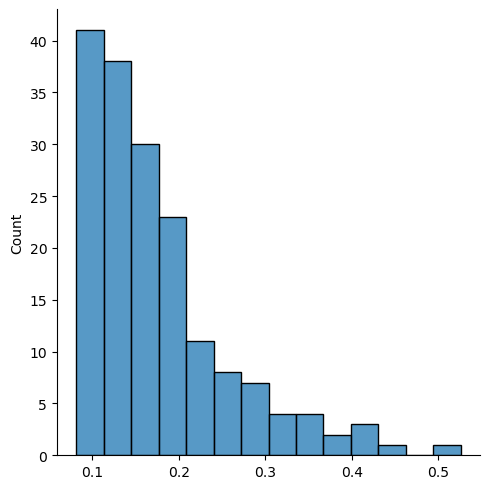

In [ ]:
sns.displot(loss_scores)

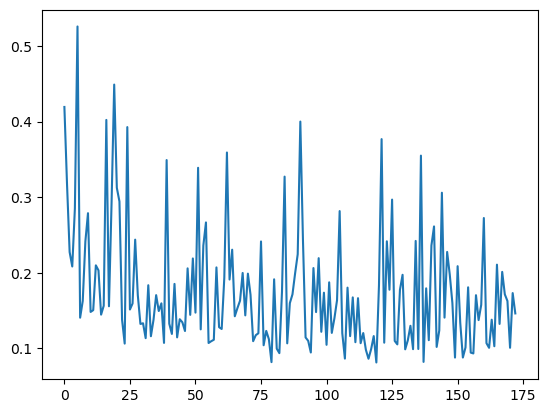

In [ ]:
plt.plot(range(len(val_loss_scores)), loss_scores)

In [ ]:
predictions = pd.DataFrame(columns=[str(i) for i in range(1296)])

test_path = Path('./images_test')

with torch.no_grad():
    for path in test_path.iterdir():
        # print(str(path).split('/')[1])
        img = torch.from_numpy(np.load(path)).unsqueeze(0).to(mps_device)
        name = str(path).split('/')[1].split('.')[0]
        pred = model(img.unsqueeze(0))
        pred = np.where(pred.cpu() >= 0.5, 1, 0).reshape(-1)
        predictions.loc[name] = pd.Series(pred, index=[str(i) for i in range(1296)])

print(predictions)
predictions.to_csv('predictions.csv')


                   0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_5_patch_1485  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_567   0  0  0  0  0  0  0  0  1  1  ...     0     0     0     0   
well_5_patch_201   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     1   
well_3_patch_57    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_419   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...               .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_3_patch_372   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_414   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_400   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_218   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_366   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                   1290  1291  1292  12